# LSOA LST builder
Build a map of LST by aggregating a number of Landsat TIR scenes, mask based on land use, and aggregate LST within LSOA boundaries

**Summary of procedure**
* Mask Landsat scenes for clouds etc using QA bitmask
* Convert Landsat scenes to LST using basic image-based rescaling and estimating TIR emissivity from Landsat-derived 
* Stack and aggregate scenes in temporal dimension
* Clip to AOI
* Mask image based on land use, to only land-use parcels of interest
* Aggregate masked LST within each LSOA region of interest
* Output both rasters and vector data of results

**Inputs**
* A given AOI box
* A set of Landsat scenes covering that box, spanning some timeframe of interest in TIR, NIR, RGB, QA bands
* Vector/raster geodata of land use/land cover classifications
* Vector geodata of LSOA boundaries

**Outputs**
* LSOA geodatabase with additional features describing LST and Land use masks
* Rasters of masked aggregated LST

### Detailed algorithm
1. List available files of Landsat data
2. Loop over files:
 * open Landsat QA file
 * extract AOI intersection
 * create QA mask
 * open Landsat TIR file
 * mask clouds etc
  * show QA contour map over L8 image and show QA mask contour 
3. aggregate scenes
4. open Land Cover data
 * extract AOI intersection
 * mask non-relevant land parcels
  * show map of Land Cover, highlighting relevant regions
5. open LSOA data
 * aggregate pixels within LSOA map
  * show map of LSOA divisions over L8 image (raster)
  * show map of derived aggregate data in LSOA divisions (vector)
6. output results
 * Masked LST raster
 * Vector data of LSOAs: rurality, LU/LC, ave LST, var LST
 * Plot LST timelines for each LSOA, all on one graph, coloured by rurality or something
 

In [1]:
""" 
Initialization
"""

import os
import glob
import pprint as pp

import numpy as np
from numpy import ma as ma
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import rasterio.plot as rplt
# ? from rasterio import Affine
from rasterio.warp import calculate_default_transform, reproject, Resampling, transform_bounds
from rasterstats import zonal_stats
from scipy.ndimage import convolve, filters

from process.common import raster_utils as ru
from process import land_surface_temperature as lst

%matplotlib inline

In [2]:
""" 
Define Inputs
"""

# Choice of Landsat scenes
l8_paths = ['202', '203']
l8_rows = ['023']

# Whether to subtract median LST from each scene before aggregating
subtract_median_lst = True 

date_label = '2014-2016'
place_label = 'derbyshire'

if date_label=='2013-2014':
    dates_of_interest = [['20131101','20140228']]
elif date_label=='2014-2016':
    dates_of_interest = [['20141101','20150228'],['20151101','20160228']]
elif date_label=='2016-2018':
    dates_of_interest = [['20161101','20170228'],['20171101','20180228']]
elif date_label=='2017-2018':
    dates_of_interest = [['20171101','20180228']]
else:
    date_label=''
    
# Where to find the files
rootdir = '/Users/nathan.bourne/data/thermcert/'
landsat_dir = rootdir+'landsat/{}_{}/L1/'.format(place_label,date_label)
tirband = '10'
qatag = 'QA'
bband = '2'
gband = '3'
rband = '4'
nband = '5'

landcover_file = rootdir+'copernicus/land_cover/g100_clc12_V18_5.tif'
lsoa_file = rootdir+'uk_data/astrosat_data/lsoa_england.geojson'
uk_counties_shapefile = rootdir+'uk_data/admin_boundaries/GB/county_region.shp'

output_plot_dir = rootdir+'output_LSOA_LST/{}_{}/'.format(place_label,date_label)
if len(glob.glob(output_plot_dir))==0:
    os.system('mkdir -p {}'.format(output_plot_dir))
else:
    print('Warning: output directory exists: {}'.format(output_plot_dir))

In [220]:
params = {
        'place_label': place_label,
        'date_label': date_label,
        'dates_of_interest': dates_of_interest,
        'pathrows': [['202','023'],['203','023']],

    }
def main(*args):
    place,date,dates = args
    print(date)
    
main(place_label,date_label,dates_of_interest)


2014-2016


In [3]:
"""
Define the AoI based on County data
"""
county_string = place_label+'*'
counties = gpd.read_file(uk_counties_shapefile) 
county_ind = np.where(counties['NAME'].str.match(county_string,case=False,na=False))[:][0]
print(county_ind,counties.iloc[county_ind]['NAME'].values)



[3] ['Derbyshire County']


In [ ]:
# # Try to access data on AWS (1) 
# # using the method from landsat-rasterio-qa-grid
# # This doesn't work because I can't get landsat-metadata-lookup-db working
# import requests


# # Define AoI in correct units
# wgs84 = {'init': 'epsg:4326'}
# counties1 = counties.to_crs(wgs84)
# print(counties1.crs)
# AoI_county_bounds = counties1.bounds.iloc[county_ind[0]].to_dict()
# print(AoI_county_bounds)

# boundaries = ','.join(str(AoI_county_bounds[i]) for i in ['minx', 'miny', 'maxx', 'maxy'])
# print(boundaries)

# # Define time interval(s):
# for SoI_counter in range(np.shape(dates_of_interest)[0]):
#     print(dates_of_interest[SoI_counter])
#     YMD0 = dates_of_interest[SoI_counter][0]
#     T0 = '-'.join([YMD0[0:4],YMD0[4:6],YMD0[6:8]])+'T00:00:00'
#     print(T0)
#     YMD1 = dates_of_interest[SoI_counter][1]
#     T1 = '-'.join([YMD1[0:4],YMD1[4:6],YMD1[6:8]])+'T23:59:59'
#     print(T1)
    
#     time_interval = (T0,T1)
#     aoi = AoI_county_bounds
#     meta_url = 'http://localhost:5005/{}/uk/scenes/{}/{},{}'.format(
#         'aws',
#         boundaries,
#         T0,
#         T1)
    
#     scenes_json = requests.get(meta_url)
    
#     if scenes_json.status_code != 200:
#         raise ValueError('Metadata service returned an error {}.'.format(scenes_json.status_code))
        
#     print(scenes_json)





In [36]:
# Access the list of available scenes on S3...
# This shouldn't be necessary because we can do lookup queries
# which will be faster (see below)
import pandas as pd
landsat_c1_scene_list = pd.read_csv('http://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz')
print(landsat_c1_scene_list.columns)

# landsat_pc_scene_list = pd.read_csv('http://landsat-pds.s3.amazonaws.com/L8/scene_list.gz')
# print(landsat_pc_scene_list.columns)

Index(['productId', 'entityId', 'acquisitionDate', 'cloudCover',
       'processingLevel', 'path', 'row', 'min_lat', 'min_lon', 'max_lat',
       'max_lon', 'download_url'],
      dtype='object')


In [40]:
print(landsat_c1_scene_list.iloc[2])


productId                   LC08_L1TP_012002_20170411_20170415_01_T1
entityId                                       LC80120022017101LGN00
acquisitionDate                           2017-04-11 15:15:03.871058
cloudCover                                                      0.38
processingLevel                                                 L1TP
path                                                              12
row                                                                2
min_lat                                                      78.7488
min_lon                                                     -29.2439
max_lat                                                      81.1455
max_lon                                                     -15.0433
download_url       https://s3-us-west-2.amazonaws.com/landsat-pds...
Name: 2, dtype: object


In [86]:
# Collection-1 matches:
myrows_c1 = ((landsat_c1_scene_list['path'].values.astype(np.int) == 203)
          & (landsat_c1_scene_list['row'].values.astype(np.int) == 23) )
print(np.sum(myrows_c1))
# print(landsat_scene_list['productId'][myrows])
sort_c1 = np.argsort(landsat_c1_scene_list['acquisitionDate'][myrows_c1].values)
print(landsat_c1_scene_list['productId'][myrows_c1].values[sort_c1])

78
['LC08_L1TP_203023_20130405_20170505_01_T1'
 'LC08_L1TP_203023_20130426_20170505_01_T1'
 'LC08_L1TP_203023_20130613_20170504_01_T1'
 'LC08_L1TP_203023_20130629_20180527_01_T1'
 'LC08_L1TP_203023_20130715_20180527_01_T1'
 'LC08_L1TP_203023_20170304_20170316_01_T1'
 'LC08_L1TP_203023_20170405_20170414_01_T1'
 'LC08_L1TP_203023_20170507_20170515_01_T1'
 'LC08_L1TP_203023_20170523_20170523_01_RT'
 'LC08_L1TP_203023_20170523_20170526_01_T1'
 'LC08_L1GT_203023_20170608_20170608_01_RT'
 'LC08_L1TP_203023_20170624_20170624_01_RT'
 'LC08_L1TP_203023_20170624_20170713_01_T1'
 'LC08_L1GT_203023_20170710_20170710_01_RT'
 'LC08_L1GT_203023_20170710_20170710_01_RT'
 'LC08_L1GT_203023_20170726_20170726_01_RT'
 'LC08_L1TP_203023_20170811_20170824_01_T1'
 'LC08_L1TP_203023_20170811_20170811_01_RT'
 'LC08_L1TP_203023_20170811_20170824_01_T1'
 'LC08_L1TP_203023_20170827_20170827_01_RT'
 'LC08_L1TP_203023_20170827_20170914_01_T1'
 'LC08_L1TP_203023_20170827_20170914_01_T1'
 'LC08_L1TP_203023_20170827_2

In [91]:
# # Pre-Collection matches:
# myrows_pc = ((landsat_pc_scene_list['path'].values.astype(np.int) == 203)
#           & (landsat_pc_scene_list['row'].values.astype(np.int) == 23) )
# print(np.sum(myrows_pc))
# # print(landsat_scene_list['productId'][myrows])
# sort_pc = np.argsort(landsat_pc_scene_list['acquisitionDate'][myrows_pc].values)
# print(landsat_pc_scene_list['productId'][myrows_pc].values[sort_pc])

In [ ]:
# # List s3 buckets:
# import boto3
# s3 = boto3.resource('s3')
# for bucket in s3.buckets.all():
#     print(bucket.name)

In [ ]:
# # Obtain credentials - not necessary if config files set up in ~/.aws

# def get_aws_creds():
#     f = open('/Users/nathan.bourne/.aws/credentials')
#     content0 = f.readline()
#     content1 = f.readline()
#     content2 = f.readline()
#     f.close()
#     key = content1.split('=')[-1].strip()
#     secret = content2.split('=')[-1].strip()
#     return key,secret
# %env AWS_ACCESS_KEY_ID,AWS_SECRET_ACCESS_KEY = get_aws_creds()



In [29]:
# Try to access data on AWS (2)
# https://gist.github.com/sgillies/7e5cd548110a5b4d45ac1a1d93cb17a3
import boto3
import re
import pandas as pd

# # Define AoI in correct units
# wgs84 = {'init': 'epsg:4326'}
# counties1 = counties.to_crs(wgs84)
# print(counties1.crs)
# AoI_county_bounds = counties1.bounds.iloc[county_ind[0]].to_dict()
# print(AoI_county_bounds)

# boundaries = ','.join(str(AoI_county_bounds[i]) for i in ['minx', 'miny', 'maxx', 'maxy'])
# print(boundaries)

# Define time interval(s):
for SoI_counter in range(np.shape(dates_of_interest)[0]):
    print(dates_of_interest[SoI_counter])
#     YMD0 = dates_of_interest[SoI_counter][0]
#     T0 = '-'.join([YMD0[0:4],YMD0[4:6],YMD0[6:8]])+'T00:00:00'
#     print(T0)
#     YMD1 = dates_of_interest[SoI_counter][1]
#     T1 = '-'.join([YMD1[0:4],YMD1[4:6],YMD1[6:8]])+'T23:59:59'
#     print(T1)
#     time_interval = (T0,T1)
    time_interval = (pd.to_datetime(dates_of_interest[SoI_counter][0]),
                     pd.to_datetime(dates_of_interest[SoI_counter][1]))
#     aoi = AoI_county_bounds
    


# Given that we already know the path,row and scene:
l8_path = '203'
l8_row = '023'
# l8_scene = 'LC08_L1TP_202023_20160223_20180527_01_T1'
# I am going to have to replace the above with some way of 
# searching the landsat_scene_list or otherwise defining the scenes 
# to look for
prefix = f'c1/L8/{l8_path}/{l8_row}/' #'{l8_scene}'

good_scenes=[]
# The following line will list scenes matching the prefix:
for objsum in boto3.resource('s3').Bucket('landsat-pds').objects.filter(Prefix=prefix,MaxKeys=99999): #,Delimiter='/'
#     print(objsum.key, objsum.size)
#     print(prefix+r'LC08_L1(\w{2})_(\d{3})(\d{3})_(\d{8})')  #/[^\.] +\.txt
    obs_meta = re.match(prefix+r'L(\w{1})08_(\w{2})(\w{2})_(\d{3})(\d{3})_(\d{8})_(\d{8})_(\d{2})_(\w{2})/[\w]+B10\.TIF$', objsum.key)
    if obs_meta is None:
        continue
    obs_meta = obs_meta.groups()
    obs_sens,obs_lev,obs_proc,obs_path,obs_row,obs_date,pro_date,coll_no,coll_cat = obs_meta
    Tobs = pd.to_datetime(obs_date)
#     print(obs_date,Tobs,Tobs<pd.to_datetime('20170101'),(Tobs-pd.to_datetime('20170101'))//pd.Timedelta('1d'))
#     print(time_interval)
#     print((Tobs>=time_interval[0]) and (Tobs<=time_interval[1]))
    if True: 
#     if Tobs<pd.to_datetime('20170101'):
#     if (Tobs>=time_interval[0]) and (Tobs<=time_interval[1]):
#         print(objsum.key)
        good_scenes += [objsum.key]
#     break

print('{} scenes found'.format(len(good_scenes)))
pp.pprint(good_scenes)

# How to interpret the filename string:
# https://docs.opendata.aws/landsat-pds/readme.html

# boto3 filter params: https://docs.aws.amazon.com/AmazonS3/latest/API/RESTBucketGET.html

['20141101', '20150228']
['20151101', '20160228']
68 scenes found
['c1/L8/203/023/LC08_L1GT_203023_20170608_20170608_01_RT/LC08_L1GT_203023_20170608_20170608_01_RT_B10.TIF',
 'c1/L8/203/023/LC08_L1GT_203023_20170710_20170710_01_RT/LC08_L1GT_203023_20170710_20170710_01_RT_B10.TIF',
 'c1/L8/203/023/LC08_L1GT_203023_20170726_20170726_01_RT/LC08_L1GT_203023_20170726_20170726_01_RT_B10.TIF',
 'c1/L8/203/023/LC08_L1GT_203023_20171115_20171115_01_RT/LC08_L1GT_203023_20171115_20171115_01_RT_B10.TIF',
 'c1/L8/203/023/LC08_L1GT_203023_20171217_20171217_01_RT/LC08_L1GT_203023_20171217_20171217_01_RT_B10.TIF',
 'c1/L8/203/023/LC08_L1GT_203023_20180102_20180102_01_RT/LC08_L1GT_203023_20180102_20180102_01_RT_B10.TIF',
 'c1/L8/203/023/LC08_L1GT_203023_20180203_20180203_01_RT/LC08_L1GT_203023_20180203_20180203_01_RT_B10.TIF',
 'c1/L8/203/023/LC08_L1GT_203023_20180219_20180219_01_RT/LC08_L1GT_203023_20180219_20180219_01_RT_B10.TIF',
 'c1/L8/203/023/LC08_L1GT_203023_20180323_20180323_01_RT/LC08_L1GT_203

In [30]:
# As above but for pre-collection
import boto3
import re
import pandas as pd

# # Define AoI in correct units
# wgs84 = {'init': 'epsg:4326'}
# counties1 = counties.to_crs(wgs84)
# print(counties1.crs)
# AoI_county_bounds = counties1.bounds.iloc[county_ind[0]].to_dict()
# print(AoI_county_bounds)

# boundaries = ','.join(str(AoI_county_bounds[i]) for i in ['minx', 'miny', 'maxx', 'maxy'])
# print(boundaries)

# Define time interval(s):
for SoI_counter in range(np.shape(dates_of_interest)[0]):
    print(dates_of_interest[SoI_counter])
#     YMD0 = dates_of_interest[SoI_counter][0]
#     T0 = '-'.join([YMD0[0:4],YMD0[4:6],YMD0[6:8]])+'T00:00:00'
#     print(T0)
#     YMD1 = dates_of_interest[SoI_counter][1]
#     T1 = '-'.join([YMD1[0:4],YMD1[4:6],YMD1[6:8]])+'T23:59:59'
#     print(T1)
#     time_interval = (T0,T1)
    time_interval = (pd.to_datetime(dates_of_interest[SoI_counter][0]),
                     pd.to_datetime(dates_of_interest[SoI_counter][1]))
#     aoi = AoI_county_bounds
    


# Given that we already know the path,row and scene:
l8_path = '203'
l8_row = '023'
# l8_scene = 'LC08_L1TP_202023_20160223_20180527_01_T1'
# I am going to have to replace the above with some way of 
# searching the landsat_scene_list or otherwise defining the scenes 
# to look for
prefix = f'L8/{l8_path}/{l8_row}/' #'{l8_scene}'

good_scenes=[]
good_scene_dates=[]
# The following line will list scenes matching the prefix:
for objsum in boto3.resource('s3').Bucket('landsat-pds').objects.filter(Prefix=prefix,MaxKeys=99999): #,Delimiter='/'
#     print(objsum.key, objsum.size)
#     print(prefix+r'LC08_L1(\w{2})_(\d{3})(\d{3})_(\d{8})')  #/[^\.] +\.txt
    search_str = r'L(\w{1,2})8(\d{3})(\d{3})(\d{4})(\d{3})(\w{3})(\w{2})/.+B10\.TIF$'
    obs_meta = re.match(prefix+search_str, objsum.key)
    if obs_meta is None:
        continue
    obs_meta = obs_meta.groups()
    obs_sens,obs_path,obs_row,obs_year,obs_jday,obs_gsi,obs_ver = obs_meta
    Tobs = pd.to_datetime(obs_year+obs_jday,format='%Y%j')
#     print(obs_date,Tobs,Tobs<pd.to_datetime('20170101'),(Tobs-pd.to_datetime('20170101'))//pd.Timedelta('1d'))
#     print(time_interval)
#     print((Tobs>=time_interval[0]) and (Tobs<=time_interval[1]))
    if True: 
#     if Tobs<pd.to_datetime('20170101'):
#     if (Tobs>=time_interval[0]) and (Tobs<=time_interval[1]):
#         print(objsum.key)
        good_scenes += [objsum.key]
        good_scene_dates += [Tobs]
#     break

print('{} scenes found in pre-collection'.format(len(good_scenes)))
pp.pprint(good_scenes)

# How to interpret the filename string:
# https://docs.opendata.aws/landsat-pds/readme.html

# boto3 filter params: https://docs.aws.amazon.com/AmazonS3/latest/API/RESTBucketGET.html
# https://boto3.amazonaws.com/v1/documentation/api/latest/guide/collections.html#guide-collections

['20141101', '20150228']
['20151101', '20160228']
87 scenes found in pre-collection
['L8/203/023/LC82030232013116LGN01/LC82030232013116LGN01_B10.TIF',
 'L8/203/023/LC82030232013132LGN01/LC82030232013132LGN01_B10.TIF',
 'L8/203/023/LC82030232013148LGN00/LC82030232013148LGN00_B10.TIF',
 'L8/203/023/LC82030232013164LGN00/LC82030232013164LGN00_B10.TIF',
 'L8/203/023/LC82030232013180LGN00/LC82030232013180LGN00_B10.TIF',
 'L8/203/023/LC82030232013196LGN00/LC82030232013196LGN00_B10.TIF',
 'L8/203/023/LC82030232013212LGN00/LC82030232013212LGN00_B10.TIF',
 'L8/203/023/LC82030232013228LGN00/LC82030232013228LGN00_B10.TIF',
 'L8/203/023/LC82030232013260LGN00/LC82030232013260LGN00_B10.TIF',
 'L8/203/023/LC82030232013276LGN00/LC82030232013276LGN00_B10.TIF',
 'L8/203/023/LC82030232013308LGN00/LC82030232013308LGN00_B10.TIF',
 'L8/203/023/LC82030232013324LGN00/LC82030232013324LGN00_B10.TIF',
 'L8/203/023/LC82030232013340LGN00/LC82030232013340LGN00_B10.TIF',
 'L8/203/023/LC82030232013356LGN00/LC82030232

In [5]:
import pandas as pd

# Let's go to google cloud
#https://cloud.google.com/storage/docs/public-datasets/landsat
#https://cloud.google.com/storage/docs/access-public-data
google_landsat_list = 'gs://gcp-public-data-landsat/index.csv.gz'
google_landsat_list = google_landsat_list.replace('gs://','http://storage.googleapis.com/')

landsat_ggl_scene_list = pd.read_csv(google_landsat_list)
print(landsat_ggl_scene_list.columns)


/Users/nathan.bourne/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['SCENE_ID', 'PRODUCT_ID', 'SPACECRAFT_ID', 'SENSOR_ID', 'DATE_ACQUIRED',
       'COLLECTION_NUMBER', 'COLLECTION_CATEGORY', 'SENSING_TIME', 'DATA_TYPE',
       'WRS_PATH', 'WRS_ROW', 'CLOUD_COVER', 'NORTH_LAT', 'SOUTH_LAT',
       'WEST_LON', 'EAST_LON', 'TOTAL_SIZE', 'BASE_URL'],
      dtype='object')


In [46]:
print(landsat_ggl_scene_list.iloc[1])
print(int(True))

SCENE_ID                                           LC80010022016246LGN01
PRODUCT_ID                      LC08_L1GT_001002_20160902_20170321_01_T2
SPACECRAFT_ID                                                  LANDSAT_8
SENSOR_ID                                                       OLI_TIRS
DATE_ACQUIRED                                                 2016-09-02
COLLECTION_NUMBER                                                      1
COLLECTION_CATEGORY                                                   T2
SENSING_TIME                                2016-09-02T14:07:46.9932600Z
DATA_TYPE                                                           L1GT
WRS_PATH                                                               1
WRS_ROW                                                                2
CLOUD_COVER                                                        95.08
NORTH_LAT                                                        81.1527
SOUTH_LAT                                          

In [6]:
# Q1 What scenes exist in the csv?

myrows_ggl_c1 = ((landsat_ggl_scene_list['WRS_PATH'].values.astype(np.int) == 203)
                  & (landsat_ggl_scene_list['WRS_ROW'].values.astype(np.int) == 23) 
                  & (landsat_ggl_scene_list['SPACECRAFT_ID'].values == 'LANDSAT_8')
                  & (landsat_ggl_scene_list['SENSOR_ID'].str.contains('TIRS'))
                  & (landsat_ggl_scene_list['COLLECTION_NUMBER'].values.astype(np.str) == '1'))
myrows_ggl_pc = ((landsat_ggl_scene_list['WRS_PATH'].values.astype(np.int) == 203)
                  & (landsat_ggl_scene_list['WRS_ROW'].values.astype(np.int) == 23) 
                  & (landsat_ggl_scene_list['SPACECRAFT_ID'].values == 'LANDSAT_8')
                  & (landsat_ggl_scene_list['SENSOR_ID'].str.contains('TIRS'))
                  & (landsat_ggl_scene_list['COLLECTION_NUMBER'].values.astype(np.str) == 'PRE'))

print('{} Collection-1 scenes found'.format(np.sum(myrows_ggl_c1)))
print('{} Pre-Collection scenes found'.format(np.sum(myrows_ggl_pc)))

# print(landsat_ggl_scene_list['PRODUCT_ID'][myrows])
sort_ggl_c1 = np.argsort(landsat_ggl_scene_list['DATE_ACQUIRED'][myrows_ggl_c1].values)
sort_ggl_pc = np.argsort(landsat_ggl_scene_list['DATE_ACQUIRED'][myrows_ggl_pc].values)
for ii in sort_ggl_c1:
    idx = (np.where(myrows_ggl_c1))[0][ii]
#     print(landsat_ggl_scene_list.iloc[idx])
    print(landsat_ggl_scene_list['PRODUCT_ID'].values[idx])

for ii in sort_ggl_pc:
    idx = (np.where(myrows_ggl_pc))[0][ii]
#     print(landsat_ggl_scene_list.iloc[idx])
    print(landsat_ggl_scene_list['SCENE_ID'].values[idx])


125 Collection-1 scenes found
86 Pre-Collection scenes found
LC08_L1TP_203023_20130405_20170505_01_T1
LC08_L1TP_203023_20130426_20170505_01_T1
LC08_L1GT_203023_20130512_20170504_01_T2
LC08_L1GT_203023_20130528_20170504_01_T2
LC08_L1TP_203023_20130613_20170504_01_T1
LC08_L1TP_203023_20130629_20180527_01_T1
LC08_L1TP_203023_20130715_20180527_01_T1
LC08_L1GT_203023_20130731_20170503_01_T2
LC08_L1TP_203023_20130816_20170503_01_T1
LC08_L1GT_203023_20130917_20170502_01_T2
LC08_L1TP_203023_20131003_20170502_01_T1
LC08_L1TP_203023_20131104_20170428_01_T1
LC08_L1TP_203023_20131120_20180527_01_T1
LC08_L1TP_203023_20131206_20170428_01_T1
LC08_L1TP_203023_20131222_20170427_01_T1
LC08_L1TP_203023_20140107_20170427_01_T1
LC08_L1TP_203023_20140123_20170426_01_T1
LC08_L1TP_203023_20140208_20170426_01_T1
LC08_L1TP_203023_20140224_20170425_01_T1
LC08_L1TP_203023_20140312_20170425_01_T1
LC08_L1TP_203023_20140328_20170424_01_T1
LC08_L1TP_203023_20140413_20170423_01_T1
LC08_L1TP_203023_20140515_20170422_01

In [31]:
# Q2 Can I manipulate the scenes in rasterio?


# # Define AoI in correct units
# wgs84 = {'init': 'epsg:4326'}
# counties1 = counties.to_crs(wgs84)
# print(counties1.crs)
# AoI_county_bounds = counties1.bounds.iloc[county_ind[0]].to_dict()
# print(AoI_county_bounds)

# boundaries = ','.join(str(AoI_county_bounds[i]) for i in ['minx', 'miny', 'maxx', 'maxy'])
# print(boundaries)

# Define time interval(s):
for SoI_counter in range(np.shape(dates_of_interest)[0]):
    print(dates_of_interest[SoI_counter])
#     YMD0 = dates_of_interest[SoI_counter][0]
#     T0 = '-'.join([YMD0[0:4],YMD0[4:6],YMD0[6:8]])+'T00:00:00'
#     print(T0)
#     YMD1 = dates_of_interest[SoI_counter][1]
#     T1 = '-'.join([YMD1[0:4],YMD1[4:6],YMD1[6:8]])+'T23:59:59'
#     print(T1)
#     time_interval = (T0,T1)
    time_interval = (pd.to_datetime(dates_of_interest[SoI_counter][0]),
                     pd.to_datetime(dates_of_interest[SoI_counter][1]))
#     aoi = AoI_county_bounds


from google.cloud import storage
storage_client = storage.Client()
bucket_name='gcp-public-data-landsat'

# Pick the earliest scene precollection
idx = (np.where(myrows_ggl_pc))[0][0]
SENSOR_ID = landsat_ggl_scene_list['SENSOR_ID'].values[idx]
PATH = landsat_ggl_scene_list['WRS_PATH'].values[idx]
ROW = landsat_ggl_scene_list['WRS_ROW'].values[idx]
SCENE_ID = landsat_ggl_scene_list['SCENE_ID'].values[idx]
precollection=True
if precollection:
    source_blob_name='gs://{}/{}/PRE/{}/{}/{}/'.format(bucket_name,
                                                       SENSOR_ID,
                                                       PATH,
                                                       ROW,
                                                       SCENE_ID)
print(source_blob_name)
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(source_blob_name)
print(type(blob))
# print(dir(blob))

# Pick the earliest scene C1
idx = (np.where(myrows_ggl_c1))[0][0]
SENSOR_ID = landsat_ggl_scene_list['SENSOR_ID'].values[idx]
PATH = landsat_ggl_scene_list['WRS_PATH'].values[idx]
ROW = landsat_ggl_scene_list['WRS_ROW'].values[idx]
PRODUCT_ID = landsat_ggl_scene_list['PRODUCT_ID'].values[idx]
precollection=False
if not precollection:
    source_blob_name='gs://{}/{}/c1/{}/{}/{}/'.format(bucket_name,
                                                       SENSOR_ID,
                                                       PATH,
                                                       ROW,
                                                       PRODUCT_ID)
print(source_blob_name)
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(source_blob_name)
print(type(blob))


# IF this is not something that rasterio can open, can it simply open it over http? as in:
with rasterio.open('https://storage.googleapis.com/gcp-public-data-landsat/LC08/PRE/063/046/LC80630462016136LGN00/LC80630462016136LGN00_B11.TIF') as src:
#     temparray = src.read()
    print('success')
# Note HTTPS for security
temparray = None

# OK, so we can open objects in the bucket with rasterio.
# Next question is can we list them and iterate over them?
# See https://cloud.google.com/storage/docs/listing-objects

def list_blobs_with_prefix(bucket_name, prefix, delimiter=None):
    """Lists all the blobs in the bucket that begin with the prefix.

    This can be used to list all blobs in a "folder", e.g. "public/".

    The delimiter argument can be used to restrict the results to only the
    "files" in the given "folder". Without the delimiter, the entire tree under
    the prefix is returned. For example, given these blobs:

        /a/1.txt
        /a/b/2.txt

    If you just specify prefix = '/a', you'll get back:

        /a/1.txt
        /a/b/2.txt

    However, if you specify prefix='/a' and delimiter='/', you'll get back:

        /a/1.txt

    """
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)

    blobs = bucket.list_blobs(prefix=prefix, delimiter=delimiter)

    print('Blobs:')
    for blob in blobs:
        print(blob.name)
        print(blob.key)
    if delimiter:
        print('Prefixes:')
        for prefix in blobs.prefixes:
            print(prefix)


# Given that we already know the path,row and scene:
l8_path = '203'
l8_row = '023'
# l8_scene = 'LC08_L1TP_202023_20160223_20180527_01_T1'
# I am going to have to replace the above with some way of 
# searching the landsat_scene_list or otherwise defining the scenes 
# to look for
prefix = f'LC08/01/{l8_path}/{l8_row}/' #'{l8_scene}'
# prefix = f'LC08/PRE/{l8_path}/{l8_row}/' #'{l8_scene}'
delimiter=None #'/'
blobs = bucket.list_blobs(prefix=prefix, delimiter=delimiter)

# list_blobs_with_prefix(bucket_name, 'LC08/PRE')

import re

good_scenes=[]
for blob in blobs:
#     print(blob.name)

    obs_meta = re.match(prefix+r'L(\w{1})08_(\w{2})(\w{2})_(\d{3})(\d{3})_(\d{8})_(\d{8})_(\d{2})_(\w{2})/[\w]+B10\.TIF$', blob.name)
    if obs_meta is None:
        continue
    obs_meta = obs_meta.groups()
    obs_sens,obs_lev,obs_proc,obs_path,obs_row,obs_date,pro_date,coll_no,coll_cat = obs_meta
    Tobs = pd.to_datetime(obs_date)
#     print(obs_date,Tobs,Tobs<pd.to_datetime('20170101'),(Tobs-pd.to_datetime('20170101'))//pd.Timedelta('1d'))
#     print(time_interval)
#     print((Tobs>=time_interval[0]) and (Tobs<=time_interval[1]))
    if True: 
#     if Tobs<pd.to_datetime('20170101'):
#     if (Tobs>=time_interval[0]) and (Tobs<=time_interval[1]):
#         print(objsum.key)
        good_scenes += [blob.name]
#     break

print('{} scenes found'.format(len(good_scenes)))
pp.pprint(good_scenes)

# # How to interpret the filename string:
# # https://docs.opendata.aws/landsat-pds/readme.html



['20141101', '20150228']
['20151101', '20160228']
gs://gcp-public-data-landsat/OLI_TIRS/PRE/203/23/LC82030232013116LGN01/
<class 'google.cloud.storage.blob.Blob'>
gs://gcp-public-data-landsat/OLI_TIRS/c1/203/23/LC08_L1GT_203023_20130512_20170504_01_T2/
<class 'google.cloud.storage.blob.Blob'>
success
169 scenes found
['LC08/01/203/023/LC08_L1GT_203023_20130512_20170504_01_T2/LC08_L1GT_203023_20130512_20170504_01_T2_B10.TIF',
 'LC08/01/203/023/LC08_L1GT_203023_20130528_20170504_01_T2/LC08_L1GT_203023_20130528_20170504_01_T2_B10.TIF',
 'LC08/01/203/023/LC08_L1GT_203023_20130731_20170503_01_T2/LC08_L1GT_203023_20130731_20170503_01_T2_B10.TIF',
 'LC08/01/203/023/LC08_L1GT_203023_20130917_20170502_01_T2/LC08_L1GT_203023_20130917_20170502_01_T2_B10.TIF',
 'LC08/01/203/023/LC08_L1GT_203023_20140616_20170421_01_T2/LC08_L1GT_203023_20140616_20170421_01_T2_B10.TIF',
 'LC08/01/203/023/LC08_L1GT_203023_20140920_20170419_01_T2/LC08_L1GT_203023_20140920_20170419_01_T2_B10.TIF',
 'LC08/01/203/023/LC0

In [32]:
# List scenes pre-collection


# Given that we already know the path,row and scene:
l8_path = '203'
l8_row = '023'
# l8_scene = 'LC08_L1TP_202023_20160223_20180527_01_T1'
# I am going to have to replace the above with some way of 
# searching the landsat_scene_list or otherwise defining the scenes 
# to look for
# prefix = f'LC08/01/{l8_path}/{l8_row}/' #'{l8_scene}'
prefix = f'LC08/PRE/{l8_path}/{l8_row}/' #'{l8_scene}'
delimiter=None #'/'
blobs = bucket.list_blobs(prefix=prefix, delimiter=delimiter)

# list_blobs_with_prefix(bucket_name, 'LC08/PRE')

import re

good_scenes=[]
for blob in blobs:
#     print(blob.name)

    search_str = r'L(\w{1,2})8(\d{3})(\d{3})(\d{4})(\d{3})(\w{3})(\w{2})/.+B10\.TIF$'
    obs_meta = re.match(prefix+search_str, blob.name)
    if obs_meta is None:
        continue
    obs_meta = obs_meta.groups()
    obs_sens,obs_path,obs_row,obs_year,obs_jday,obs_gsi,obs_ver = obs_meta
    Tobs = pd.to_datetime(obs_year+obs_jday,format='%Y%j')
#     print(obs_date,Tobs,Tobs<pd.to_datetime('20170101'),(Tobs-pd.to_datetime('20170101'))//pd.Timedelta('1d'))
#     print(time_interval)
#     print((Tobs>=time_interval[0]) and (Tobs<=time_interval[1]))
    if True: 
#     if Tobs<pd.to_datetime('20170101'):
#     if (Tobs>=time_interval[0]) and (Tobs<=time_interval[1]):
#         print(objsum.key)
        good_scenes += [blob.name]
#     break

print('{} scenes found'.format(len(good_scenes)))
pp.pprint(good_scenes)

# # How to interpret the filename string:
# # https://docs.opendata.aws/landsat-pds/readme.html


86 scenes found
['LC08/PRE/203/023/LC82030232013116LGN01/LC82030232013116LGN01_B10.TIF',
 'LC08/PRE/203/023/LC82030232013132LGN01/LC82030232013132LGN01_B10.TIF',
 'LC08/PRE/203/023/LC82030232013148LGN00/LC82030232013148LGN00_B10.TIF',
 'LC08/PRE/203/023/LC82030232013164LGN00/LC82030232013164LGN00_B10.TIF',
 'LC08/PRE/203/023/LC82030232013180LGN00/LC82030232013180LGN00_B10.TIF',
 'LC08/PRE/203/023/LC82030232013196LGN00/LC82030232013196LGN00_B10.TIF',
 'LC08/PRE/203/023/LC82030232013212LGN00/LC82030232013212LGN00_B10.TIF',
 'LC08/PRE/203/023/LC82030232013228LGN00/LC82030232013228LGN00_B10.TIF',
 'LC08/PRE/203/023/LC82030232013260LGN00/LC82030232013260LGN00_B10.TIF',
 'LC08/PRE/203/023/LC82030232013276LGN00/LC82030232013276LGN00_B10.TIF',
 'LC08/PRE/203/023/LC82030232013308LGN00/LC82030232013308LGN00_B10.TIF',
 'LC08/PRE/203/023/LC82030232013324LGN00/LC82030232013324LGN00_B10.TIF',
 'LC08/PRE/203/023/LC82030232013340LGN00/LC82030232013340LGN00_B10.TIF',
 'LC08/PRE/203/023/LC82030232013356

In [154]:
# Test my module
from process import landsat
import imp
imp.reload(landsat)

aws = landsat.aws()
tab = aws.read_scene_list()

In [87]:
rows = aws.find_in_scene_list(tab,path=203,row=23,maxDate='20190101')
sort = np.argsort(tab['acquisitionDate'][rows].values)
print(len(sort))


78


In [111]:
imp.reload(landsat)
aws = landsat.aws()
# print(pd.to_datetime(pd.Timestamp.min))
myscenes,mydates = aws.find_in_bucket(l8_path,l8_row,4)
print(len(myscenes))
sort = np.argsort(mydates)


68


In [112]:
with rasterio.open(aws.https_stub+myscenes[sort][0]) as src:
    print('success')

success


In [115]:
import rasterio
session = rasterio.session.AWSSession(profile_name='default')
with rasterio.Env(session=session):
    with rasterio.open(aws.s3_stub+myscenes[sort][0]) as src:
        print('success')

success


In [130]:
# Test GCS
imp.reload(landsat)

gcs = landsat.gcs()
tab = gcs.read_scene_list()

In [135]:
imp.reload(landsat)
rows = gcs.find_in_scene_list(tab,path=203,row=23,maxDate='20190101',Collection=0)
sort = np.argsort(tab['DATE_ACQUIRED'][rows].values)
print(len(sort))


86


In [162]:
imp.reload(landsat)

gcs = landsat.gcs()
myscenes,mydates = gcs.find_in_bucket(l8_path,l8_row,1,maxDate='20190101',Collection=False)
print(len(myscenes))
sort = np.argsort(mydates)


86


In [221]:
imp.reload(landsat)
gcs = landsat.gcs()
# print(pd.to_datetime(pd.Timestamp.min))
myscenes,mydates = gcs.find_in_bucket(l8_path,l8_row,10,minDate='20141101',maxDate='20150228')
print(len(myscenes))
sort = np.argsort(mydates)
print(np.array(myscenes)[sort])

7
['LC08/01/203/023/LC08_L1GT_203023_20141107_20170417_01_T2/LC08_L1GT_203023_20141107_20170417_01_T2_B10.TIF'
 'LC08/01/203/023/LC08_L1GT_203023_20141123_20170417_01_T2/LC08_L1GT_203023_20141123_20170417_01_T2_B10.TIF'
 'LC08/01/203/023/LC08_L1GT_203023_20141209_20170416_01_T2/LC08_L1GT_203023_20141209_20170416_01_T2_B10.TIF'
 'LC08/01/203/023/LC08_L1TP_203023_20141225_20170416_01_T1/LC08_L1TP_203023_20141225_20170416_01_T1_B10.TIF'
 'LC08/01/203/023/LC08_L1TP_203023_20150110_20170415_01_T1/LC08_L1TP_203023_20150110_20170415_01_T1_B10.TIF'
 'LC08/01/203/023/LC08_L1TP_203023_20150126_20170413_01_T1/LC08_L1TP_203023_20150126_20170413_01_T1_B10.TIF'
 'LC08/01/203/023/LC08_L1TP_203023_20150227_20170412_01_T1/LC08_L1TP_203023_20150227_20170412_01_T1_B10.TIF']


In [167]:
with rasterio.open(gcs.https_stub+myscenes[sort][0]) as src:
    arr = src.read(out_shape=(src.height//100, src.width//100))
    print('success')

success


{'init': 'epsg:4326'}
{'minx': -2.034097844958567, 'miny': 52.69651854314961, 'maxx': -1.1664888198647425, 'maxy': 53.54045238430677}
[3]
LC08/01/203/023/LC08_L1GT_203023_20141107_20170417_01_T2/LC08_L1GT_203023_20141107_20170417_01_T2_B10.TIF
+init=epsg:32630
{'minx': 564268.9167180521, 'miny': 5839423.373395093, 'maxx': 622250.913290278, 'maxy': 5932982.743347965}
{'minx': 397828.4983, 'miny': 311054.9008, 'maxx': 455676.2015, 'maxy': 404874.6952}
(563999.4778136064, 5839021.965117169, 623155.837690716, 5933646.987290756)
{'minx': 563999.4778136064, 'miny': 5839021.965117169, 'maxx': 623155.837690716, 'maxy': 5933646.987290756}
2384 2242 1933 3119
(1, 3119, 1933)
2362 2272 1972 3154
(1, 3154, 1972)
success
['__attrs_attrs__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '

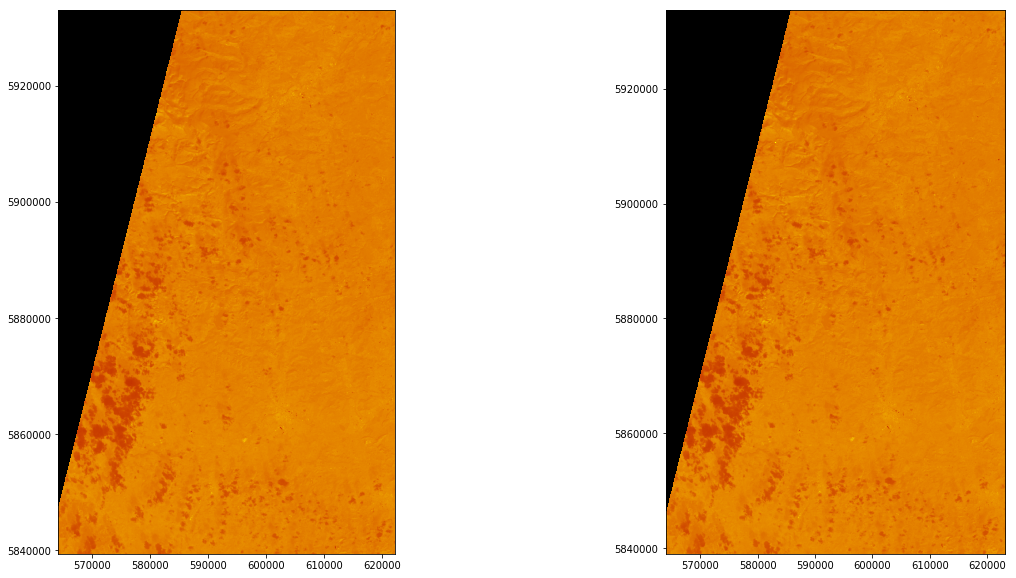

In [240]:
# Window read

# Define AoI in correct units
wgs84 = {'init': 'epsg:4326'}
counties1 = counties.to_crs(wgs84)
print(counties1.crs)
AoI_county_bounds = counties1.bounds.iloc[county_ind[0]].to_dict()
print(AoI_county_bounds)
print(county_ind)

scene_path = 'LC08/01/202/023/LC08_L1TP_202023_20160223_20180527_01_T1/LC08_L1TP_202023_20160223_20180527_01_T1_B10.TIF'
with rasterio.open(gcs.https_stub+scene_path) as src:
    print(np.array(myscenes)[sort][0])
    print(src.crs)
    AoIbounds = counties.to_crs(src.crs).bounds.iloc[county_ind[0]].to_dict()
    print(AoIbounds)
    AoIbounds2 = counties.bounds.iloc[county_ind[0]].to_dict()
    print(AoIbounds2)
    AoIbounds2 = rasterio.warp.transform_bounds(counties.crs,src.crs,*AoIbounds2.values())
    print(AoIbounds2)
    AoIbounds2=dict(zip(('minx','miny','maxx','maxy'),AoIbounds2))
    print(AoIbounds2)
    AoIrow0,AoIcol0 = rasterio.transform.rowcol(src.transform,AoIbounds['minx'],AoIbounds['maxy'])
    AoIrow1,AoIcol1 = rasterio.transform.rowcol(src.transform,AoIbounds['maxx'],AoIbounds['miny'])
    AoIheight,AoIwidth = AoIrow1 - AoIrow0, AoIcol1 - AoIcol0
    print(AoIrow0,AoIcol1,AoIwidth,AoIheight)
    window = rasterio.windows.Window(AoIcol0,AoIrow0,AoIwidth,AoIheight)
    
#     window = rasterio.windows.WindowMethodsMixin.window
    arr = src.read(window=window)
    wtran = src.window_transform(window)
    print(arr.shape)
    
    fig,ax = plt.subplots(1,2,figsize=(20,10))
    rasterio.plot.show(arr[0],transform=wtran, ax=ax[0], cmap='gnuplot')
    
    AoIbounds=AoIbounds2
    AoIrow0,AoIcol0 = rasterio.transform.rowcol(src.transform,AoIbounds['minx'],AoIbounds['maxy'])
    AoIrow1,AoIcol1 = rasterio.transform.rowcol(src.transform,AoIbounds['maxx'],AoIbounds['miny'])
    AoIheight,AoIwidth = AoIrow1 - AoIrow0, AoIcol1 - AoIcol0
    print(AoIrow0,AoIcol1,AoIwidth,AoIheight)
    window = rasterio.windows.Window(AoIcol0,AoIrow0,AoIwidth,AoIheight)
    arr = src.read(window=window)
    wtran = src.window_transform(window)
    print(arr.shape)
    
    rasterio.plot.show(arr[0],transform=wtran, ax=ax[1], cmap='gnuplot')
    
    print('success')
    print(dir(window))
    
    

In [4]:
# Try to access scenes on AWS (3)

import boto3
session = boto3.Session(profile_name='default')


# Given that we already know the path,row and scene:
l8_path = '205'
l8_row = '021'
l8_scene = 'LC08_L1TP_205021_20180625_20180704_01_T1'
band = '4'
# I am going to have to replace the above with some way of 
# searching the landsat_scene_list or otherwise defining the scenes 
# to look for
prefix = f'c1/L8/{l8_path}/{l8_row}/{l8_scene}'

with rasterio.Env(session=session):
    with rasterio.open(
        f's3://landsat-pds/{prefix}/{l8_scene}_B{band}.TIF') as src:
            print('success')

success


## 1. List available files

In [222]:
all_metadata = glob.glob(os.path.join(landsat_dir,'*MTL.txt'))

# Select those within the date range
scenes_metadata = []
for file in all_metadata:
    fsat,flev,frowpath,fobs_date,fpro_date,fetc1,fetc2,fext = file.split('/')[-1].split('_')
    #print((int(fobs_date),dates_of_interest))
    #print([type(a[1]) for a in dates_of_interest])
    #print([(int(fobs_date)<=a[1]) & (int(fobs_date)>=a[0]) for a in dates_of_interest])
    if (np.sum([(int(fobs_date)<=int(a[1])) & (int(fobs_date)>=int(a[0])) 
                for a in dates_of_interest]
              ))>0:
        # the date of this file is within one of the date ranges of interest
        scenes_metadata += [file]

        

scenes_bqa = ['{}B{}.TIF'.format(name[:-7],qatag) for name in scenes_metadata]
scenes_tir = ['{}B{}.TIF'.format(name[:-7],tirband) for name in scenes_metadata]

scenes_b = ['{}B{}.TIF'.format(name[:-7],bband) for name in scenes_metadata]
scenes_g = ['{}B{}.TIF'.format(name[:-7],gband) for name in scenes_metadata]
scenes_r = ['{}B{}.TIF'.format(name[:-7],rband) for name in scenes_metadata]
scenes_nir = ['{}B{}.TIF'.format(name[:-7],nband) for name in scenes_metadata]
pp.pprint(scenes_tir)
# Remember to unzip them!


['/Users/nathan.bourne/data/thermcert/landsat/derbyshire_2014-2016/L1/LC08_L1TP_202023_20160207_20170330_01_T1_B10.TIF',
 '/Users/nathan.bourne/data/thermcert/landsat/derbyshire_2014-2016/L1/LC08_L1TP_202023_20160223_20180527_01_T1_B10.TIF',
 '/Users/nathan.bourne/data/thermcert/landsat/derbyshire_2014-2016/L1/LC08_L1GT_203023_20141107_20170417_01_T2_B10.TIF',
 '/Users/nathan.bourne/data/thermcert/landsat/derbyshire_2014-2016/L1/LC08_L1TP_203023_20150110_20170415_01_T1_B10.TIF',
 '/Users/nathan.bourne/data/thermcert/landsat/derbyshire_2014-2016/L1/LC08_L1TP_203023_20141225_20170416_01_T1_B10.TIF',
 '/Users/nathan.bourne/data/thermcert/landsat/derbyshire_2014-2016/L1/LC08_L1TP_203023_20150227_20170412_01_T1_B10.TIF',
 '/Users/nathan.bourne/data/thermcert/landsat/derbyshire_2014-2016/L1/LC08_L1TP_203023_20160214_20170330_01_T1_B10.TIF',
 '/Users/nathan.bourne/data/thermcert/landsat/derbyshire_2014-2016/L1/LC08_L1TP_202023_20150119_20170413_01_T1_B10.TIF',
 '/Users/nathan.bourne/data/ther

In [223]:
print(scenes_metadata[0])


/Users/nathan.bourne/data/thermcert/landsat/derbyshire_2014-2016/L1/LC08_L1TP_202023_20160207_20170330_01_T1_MTL.txt


## 2. Read Landsat data
- open Landsat QA file
- extract AOI intersection
- create QA mask
- open Landsat TIR file
- mask clouds etc
- show QA contour map over L8 image and show QA mask contour


The QA band bits are defined as follows:
- for Landsat-8 pre-collection (files without underscores) [here](https://landsat.usgs.gov/landsat-8-l8-data-users-handbook-section-5)
- for Landsat-8 collection (files ending in `_T1` or `_T2` or `_RT`) [here](https://landsat.usgs.gov/collectionqualityband)
- the filename Scene IDs are described [here](https://landsat.usgs.gov/landsat-collections#Prod%20IDs)

For the collection files, the 16-bit (not 8-bit) QA flags:
- bit 0 = designated fill: mask
- bit 1 = terrain occulsion: mask
- bit 2-3 = saturation: don't mask
- bit 4 = cloud: either mask this or use the confidence flags below
- bit 5-6 = cloud confidence
- bit 7-8 = cloud shadow confidence
- bit 9-10 = snow/ice confidence
- bit 11-12 = cirrus confidence

>***NB this section could/should be replaced by query of AWS S3 Bucket***

In [ ]:
"""
Loop over the scenes and check the QA flags

This block simply makes figures showing the QA mask values alongside the TIR scenes
It can be skipped if those figures aren't wanted
"""
%matplotlib agg
pp.pprint(('Legend:' ,
            'Magenta = terrain occlusion',
            'white = cloud bit',
            'Red = cloud conf med/high',
            'Cyan = cirrus conf med/high',
            'Blue = cloud shadow conf med/high',
            'Green = snow/ice conf med/high'))

counter=-1
for scene_metadata, scene_bqa, scene_tir in zip(scenes_metadata,
                                                scenes_bqa,scenes_tir):
    counter+=1
#     if counter>0:
#         continue
    
    # this syntax ensures files are closed if there is an exception
    with rasterio.open(scene_bqa) as bqa:
        with rasterio.open(scene_tir) as tir:
            bqa_data = bqa.read()[0,:,:]
    
            tir_data = tir.read()[0,:,:]
            tir_data = ma.array(tir_data,dtype=float,
                                mask=ru.mask_qa(bqa_data,bitmask=0b1))

#             fig,ax=plt.subplots(1,2,figsize=(10,5))
            fig,ax=plt.subplots(1,2,figsize=(40,20))
            

            # The following lines don't seem to treat the 
            # transform correctly, whether or not the data array 
            # is flattened to 2d
            #rplt.show(bqa,ax=ax[0],cmap='nipy_spectral')
            #rplt.show(tir_data,ax=ax[1],cmap='gray',
            #          transform=tir.transform)
            
#             rplt.show(bqa_data,ax=ax[0],cmap='gray')
#             rplt.show(tir_data,ax=ax[1],cmap='gray')
            
            smw = 11
            (ymin,ymax) = (0, tir_data.shape[0])
            (xmin,xmax) = (0, tir_data.shape[1])
#             (ymin,ymax) = (3500,5500)
#             (xmin,xmax) = (4500,6500)
            
            ax1=ax[0]
            tir_data_rescale=ru.rescale_image(tir_data,kind='hist_eq')
            #rplt.show(tir_data_rescale,ax=ax1,cmap='Greys')
            rplt.show(tir_data_rescale[ymin:ymax,xmin:xmax],ax=ax1,cmap='Greys')
            
            # contour
            from scipy.ndimage import convolve, filters
            mask_occ_sm = filters.maximum_filter(ru.mask_qa(bqa_data,bits=[1]),size=smw)
            mask_cloud_sm = filters.maximum_filter(ru.mask_qa(bqa_data,bits=[0,4]),size=smw)
            mask_clcon_sm = filters.maximum_filter(ru.mask_qa(bqa_data,bits=[6]),size=smw)
            mask_cicon_sm = filters.maximum_filter(ru.mask_qa(bqa_data,bits=[12]),size=smw)
            mask_cscon_sm = filters.maximum_filter(ru.mask_qa(bqa_data,bits=[8]),size=smw)
            mask_sncon_sm = filters.maximum_filter(ru.mask_qa(bqa_data,bits=[10]),size=smw)

#             ax1.contour(mask_occ_sm,levels=[0.5],
#                           colors='magenta',linewidths=0.5,antialiased=True)
#             ax1.contour(mask_cloud_sm,levels=[0.5],
#                           colors='white',linewidths=0.5,antialiased=True)
#             ax1.contour(mask_clcon_sm,levels=[0.5],
#                           colors='red',linewidths=0.5,antialiased=True)
#             ax1.contour(mask_cicon_sm,levels=[0.5],
#                           colors='cyan',linewidths=0.5,antialiased=True)
#             ax1.contour(mask_cscon_sm,levels=[0.5],
#                           colors='blue',linewidths=0.5,antialiased=True)
#             ax1.contour(mask_sncon_sm,levels=[0.5],
#                           colors='green',linewidths=0.5,antialiased=True)
            
#           # Filled contours
            ax1.contourf(mask_occ_sm[ymin:ymax,xmin:xmax],levels=[0.5,1],
                           colors='magenta',antialiased=True)
#             ax1.contourf(mask_cloud_sm[ymin:ymax,xmin:xmax],levels=[0.5,1],
#                            colors='white',antialiased=True)
            ax1.contourf(mask_sncon_sm[ymin:ymax,xmin:xmax],[0.5,1],
                           colors='green',antialiased=True)
            ax1.contourf(mask_cscon_sm[ymin:ymax,xmin:xmax],[0.5,1],
                           colors='blue',antialiased=True)
            ax1.contourf(mask_clcon_sm[ymin:ymax,xmin:xmax],[0.5,1],
                           colors='red',antialiased=True)
            ax1.contourf(mask_cicon_sm[ymin:ymax,xmin:xmax],[0.5,1],
                           colors='cyan',antialiased=True)
            
            # Unfilled contour for the simple cloud bit
            ax1.contour(mask_cloud_sm[ymin:ymax,xmin:xmax],levels=[0.5],
                           colors='white',linewidths=0.5,antialiased=True)
             
            mask_all = filters.maximum_filter(
                ru.mask_qa(bqa_data,bits=[0,1,4,8,10]),size=smw
            )
            tir_data_mask_all = ma.array(tir_data,
                                mask=mask_all,
                                fill_value=0).filled()

            tir_data_mask_rescale = ru.rescale_image(tir_data_mask_all,kind='hist_eq')
            
            
            
            ax2=ax[1]
            #rplt.show(tir_data_mask_rescale,ax=ax2,cmap='hot')
            rplt.show(tir_data_mask_rescale[ymin:ymax,xmin:xmax],ax=ax2,cmap='hot')
            
            fig.suptitle('{}: {} smw={}'.format(counter, scene_tir, smw),fontsize='large')
            
            scene_stub = scene_tir[:-4].split('/')[-1]
            filename=output_plot_dir+scene_stub+'_mask_check.png'
            fig.savefig(filename)
            print(filename)
print('all done')

In [ ]:
"""
Make RGB images

This cell simply makes figures showing the RGB images of each scene
This can be skipped
"""
%matplotlib agg

for (scene_b,scene_g,scene_r,scene_bqa) in zip(scenes_b,scenes_g,scenes_r,scenes_bqa):
    with rasterio.open(scene_b) as blue:
        with rasterio.open(scene_g) as green:
            with rasterio.open(scene_r) as red:
                with rasterio.open(scene_bqa) as bqa:
                    bqa_data = bqa.read()[0,:,:]
                    blue_data = blue.read()[0,:,:]
                    green_data = green.read()[0,:,:]
                    red_data = red.read()[0,:,:]
                    #for arr in (bluedata,greendata,reddata):
                    #    arr = ru.rescale_image(arr,kind='linear')
                    
                    for arr in (blue_data,green_data,red_data):
                        arr = ma.array(arr,dtype=float,
                                    mask=ru.mask_qa(bqa_data,bits=[0]),
                                    fill_value=0.).filled()
                        
                    rgb_data = np.array(np.dstack([red_data,green_data,blue_data]),dtype=float)
                    #rgb_data = ma.concatenate([red_data,green_data,blue_data], axis=2)
                                        
                    rgb_data = ru.rescale_image(rgb_data,kind='clahe')
                    pmin,pmax = np.percentile(rgb_data[rgb_data>0],[0,75])
                    
                    fig,ax=plt.subplots(figsize=(20,20))
                    ax.imshow(rgb_data[ymin:ymax,xmin:xmax,:],vmin=pmin,vmax=pmax)

                    scene_stub = scene_r[:-6].split('/')[-1]
                    filename=output_plot_dir+scene_stub+'RGB.png' 
                    fig.savefig(filename)
                    print(filename)
                     
                    
print('all done')

## 2a. Extract AOI Intersection

In [ ]:
# Change coordinate system of counties data to match Landsat scene
with rasterio.open(scenes_bqa[0]) as scene:
    pp.pprint(scene.crs)
    pp.pprint(scene.bounds)
    
    counties = counties.to_crs(scene.crs)


In [ ]:
aoi_box = counties.bounds.loc[county_ind[0]]
print(aoi_box)

In [ ]:
"""
Make RGB images clipped to AoI 

Again this is optional
"""

## https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html

%matplotlib agg

for (scene_b,scene_g,scene_r,scene_bqa) in zip(scenes_b,scenes_g,scenes_r,scenes_bqa):
    with rasterio.open(scene_b) as blue:
        with rasterio.open(scene_g) as green:
            with rasterio.open(scene_r) as red:
                with rasterio.open(scene_bqa) as bqa:
                    
#                     # Following should work but my version of rasterio has no `mask`
#                     out_blue, out_transform_blue = rasterio.mask.mask(blue, aoi_box, crop=True)
#                     out_green, out_transform_green = rasterio.mask.mask(green, aoi_box, crop=True)
#                     out_red, out_transform_red = rasterio.mask.mask(red, aoi_box, crop=True)
#                     out_bqa, out_transform_bqa = rasterio.mask.mask(bqa, aoi_box, crop=True)
                    
                    # Instead use the aoi_box bounds to set min,max array indices to work with, 
                    #  using dataset.index() to convert physical units to indices
                    # Or maybe update the bounds metadata of the image
                    # Or use a mask array as with the cloud masks
                    # Or even work with a rasterio `window` data set to preserve memory...
                    intersect = ru.aoi_scene_intersection(aoi_box,bqa)
                    left, bottom, right, top = intersect.bounds
                    rowmin,colmin = (bqa.index(left,top))
                    rowmax,colmax = (bqa.index(right,bottom))
                    
                    bqa_data = bqa.read()[0,rowmin:rowmax,colmin:colmax]
                    blue_data = blue.read()[0,rowmin:rowmax,colmin:colmax]
                    green_data = green.read()[0,rowmin:rowmax,colmin:colmax]
                    red_data = red.read()[0,rowmin:rowmax,colmin:colmax]
                    #for arr in (bluedata,greendata,reddata):
                    #    arr = ru.rescale_image(arr,kind='linear')
                    
                    for arr in (blue_data,green_data,red_data):
                        arr = ma.array(arr,dtype=float,
                                    mask=ru.mask_qa(bqa_data,bits=[0]),
                                    fill_value=0.).filled()
                        
                    rgb_data = np.array(np.dstack([red_data,green_data,blue_data]),dtype=float)
                    #rgb_data = ma.concatenate([red_data,green_data,blue_data], axis=2)
                                        
                    #print(np.shape(rgb_data))
                    rgb_data = ru.rescale_image(rgb_data,kind='clahe')
                    pmin,pmax = np.percentile(rgb_data[rgb_data>0],[0,75])
                    
                    fig,ax=plt.subplots(figsize=(20,20))
                    ax.imshow(rgb_data)
                    
                    scene_stub = scene_r[:-6].split('/')[-1]
                    filename=output_plot_dir+scene_stub+'clip_RGB.png'
                    fig.savefig(filename)
                    print(filename)
print('all done')

# 3. Aggregate scenes

Now we open up all the TIR scenes, reproject them to a common grid and stack them in a single array

Then output a TIF file of the stack

Also output stats of the stack 

In [ ]:
# """
# Aggregate clipped and masked TIR scenes
# """
# %matplotlib inline
              
# counter=-1
# for scene_metadata, scene_bqa, scene_tir in zip(scenes_metadata,
#                                                 scenes_bqa,scenes_tir):
#     counter+=1
#     with rasterio.open(scene_bqa) as bqa:
#         with rasterio.open(scene_tir) as tir:
#             bqa_data = bqa.read()[0,:,:]
#             tir_data = tir.read()[0,:,:]

#             # Determine size of stack allowing for AoI to extend outside of scene
#             if counter == 0:
#                 left, bottom, right, top = aoi_box
#                 rowmin,colmin = (bqa.index(left,top))
#                 rowmax,colmax = (bqa.index(right,bottom))
#                 stack_height,stack_width = (rowmax-rowmin,colmax-colmin)
#                 tir_stack = ma.zeros((len(scenes_bqa),stack_height,stack_width))
            
#             # Determine size of intersect
#             intersect = ru.aoi_scene_intersection(aoi_box,bqa)
#             left, bottom, right, top = intersect.bounds
#             rowmin,colmin = (bqa.index(left,top))
#             rowmax,colmax = (bqa.index(right,bottom))
            
#             # Read data 
#             bqa_data = bqa.read()[0,rowmin:rowmax,colmin:colmax]
#             tir_data = tir.read()[0,rowmin:rowmax,colmin:colmax]

#             # Masks
#             smw = 11
#             mask_all = filters.maximum_filter(
#                 ru.mask_qa(bqa_data,bits=[0,1,4,8,10]),size=smw
#             )
#             tir_data_mask_all = ma.array(tir_data,
#                                 mask=mask_all,
#                                 fill_value=0)#.filled()
            
#             # After masking, reproject
#             # Actually I don't think this is necessary if they share a CRS
#             if counter > 0:
#                 assert tir.crs == prev_crs
#             prev_crs = tir.crs
            
#             # Then add to stack
#             tir_stack[counter,:,:] = tir_data_mask_all
            
#             # Make plot of individual scene AoI
#             fig,ax1 = plt.subplots(figsize=(20,20))
#             tir_data_mask_rescale = ru.rescale_image(tir_data_mask_all,kind='hist_eq')
#             rplt.show(tir_data_mask_rescale,ax=ax1,cmap='hot')
            
#             fig.suptitle('{}: {} smw={}'.format(counter, scene_tir, smw),fontsize='large')
            
#             scene_stub = scene_tir[:-4].split('/')[-1]
#             filename = output_plot_dir+scene_stub+'_clip_masked.png'
#             fig.savefig(filename)
#             print(filename)
            
# print('all done')


In [ ]:
# """
# Now output the stack data as GeoTIFF
# """
# N_layers = counter+1
# with rasterio.Env():
#     scene_tir=scenes_tir[0]
#     with rasterio.open(scene_tir) as tir:
#         profile = tir.profile
#         #intersect = ru.aoi_scene_intersection(aoi_box,tir)
#         #left, bottom, right, top = intersect.bounds
#     left, bottom, right, top = aoi_box
            
#     profile.update(
#         dtype=rasterio.float64,
#         width=tir_stack.shape[2],
#         height=tir_stack.shape[1],
#         transform=rasterio.transform.from_origin(
#                 left, 
#                 top, 
#                 ru.rst_transform(tir)[0], 
#                 abs(ru.rst_transform(tir)[4])
#                 ),
#         count=N_layers,
#         compress='lzw'
#     )
#     print(N_layers)
#     print(tir_stack.shape)
#     with rasterio.open(output_plot_dir+'B{}_stack.tif'.format(tirband), 'w', **profile) as dst:
#         dst.write(tir_stack)


In [ ]:
# """
# Do stats
# """
# tir_count = tir_stack.count(axis=0)
# tir_mean = tir_stack.mean(axis=0)
# tir_var = tir_stack.var(axis=0)
# fig,axes = plt.subplots(2,2,figsize=(15,20))
# rplt.show_hist(tir_count,ax=axes.flatten()[0])
# rplt.show(tir_count,vmin=0,vmax=9,cmap='nipy_spectral',ax=axes.flatten()[1],title='Count')
# rplt.show(rescale_image(tir_mean,kind='hist_eq'),cmap='afmhot',ax=axes.flatten()[2],title='Mean')
# rplt.show(rescale_image(tir_var/tir_count,kind='hist_eq'),cmap='afmhot',ax=axes.flatten()[3],title='Variance/N')

In [ ]:
# """
# Pixel histograms of individual scenes
# """
# fig,axes = plt.subplots(3,3,figsize=(20,12))
# for ii in range(9):
#     rplt.show_hist(tir_stack[ii,:,:],ax=axes.flatten()[ii])


## 3a. Convert to LST before aggregating

Initially just use LST calculation from Astrosat `land-surface-temperature`

In [ ]:
"""
Convert a single scene to LST

Don't need to run this cell
"""
%matplotlib agg

scn_ind=1

scene_metadata, scene_bqa, scene_tir, scene_red, scene_nir = (
     scenes_metadata[scn_ind],scenes_bqa[scn_ind],scenes_tir[scn_ind],
     scenes_r[scn_ind], scenes_nir[scn_ind]
)
with rasterio.open(scene_bqa) as bqa:
    with rasterio.open(scene_tir) as tir:
        with rasterio.open(scene_red) as red:
            with rasterio.open(scene_nir) as nir:
                bqa_data = ma.array(bqa.read()[0,:,:])
                tir_data = ma.array(tir.read()[0,:,:])
                red_data = ma.array(red.read()[0,:,:])
                nir_data = ma.array(nir.read()[0,:,:])
                
                tirs_transform = ru.rst_transform(tir)
                oli_transform = ru.rst_transform(red)
                
                lst_data = \
                lst.calculate_land_surface_temperature_NB(
                        red_data, nir_data, tir_data,
                        oli_transform, tirs_transform, 
                        red.crs, tir.crs, scene_metadata
                )
#                 print(tir_data.shape)
#                 print(red_data.shape)
#                 print(nir_data.shape)
#                 print(lst_data.shape)
                
                
                # Masks
                smw = 11
                mask_all = filters.maximum_filter(
                    ru.mask_qa(bqa_data,bits=[0,1,4,8,10]),size=smw
                )
                lst_data_mask_all = ma.array(lst_data,
                                    mask=mask_all,
                                    fill_value=0)#.filled()
                # Masks
                tir_data_mask_all = ma.array(tir_data,
                                    mask=mask_all,
                                    fill_value=0)#.filled()
            
                #lst_data_mask_rescale = rescale_image(lst_data_mask_all,kind='linear')
                #tir_data_mask_rescale = rescale_image(tir_data_mask_all,kind='linear')
                
                fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,20))
                #im1 = rplt.show(tir_data_mask_all,ax=ax1,cmap='hot')
                im1 = ax1.imshow(tir_data_mask_all,cmap='hot')
                CB1 = fig.colorbar(im1, orientation='horizontal', shrink=0.8, ax=ax1)
                ax1.set_title('TIR units')
                CB1.set_label('DNs')
                
                #im2 = rplt.show(lst_data_mask_all,ax=ax2,cmap='hot')
                im2 = ax2.imshow(lst_data_mask_all,cmap='hot')
                CB2 = fig.colorbar(im2, orientation='horizontal', shrink=0.8, ax=ax2)
                ax2.set_title('LST units')
                CB2.set_label('Centigrade')
                
                
                
                

In [ ]:
test1 = ma.zeros((8,2),dtype=np.float,fill_value=np.nan)
print(test1)

test2 = ma.array([1,2,3,4,5,6,7,8],mask=[True]+[False]*7,
                 dtype=np.float,fill_value=np.nan)
print(test2)

test3 = ma.array([11,12,13,14,15,16,17,18],mask=[True]*2+[False]*6,
                 dtype=np.float,fill_value=np.nan)
print(test3)

test1[:,0] = test2
test1[:,1] = test3

print(test1)
print(test1.mean(axis=1))

In [ ]:
def get_ceda_password():
    f = open('/Users/nathan.bourne/data/thermcert/uk_data/ceda_password.txt')
    content = f.readline()
    f.close()
    return content

In [ ]:
"""
Convert clipped and masked TIR scenes to LST, then aggregate 
Also allow for calculation of xLST: subtracting mean air temp 
on day of acquisition, and aggregating the result

This has to be re-run each time you want to produce xLST,rxLST,rLST stacks
"""
subtract_air_temp = True  # If True then xLST
subtract_median_lst = True # If True then rLST
#                           If both True then rxLST
if subtract_air_temp:
    from script import met_climate
    import imp
    imp.reload(met_climate)

    ceda_password = get_ceda_password()
    ceda_username = 'nbourne'

    at = met_climate.access_ukcp09(ceda_username,ceda_password)


%matplotlib agg

counter=-1
for scene_metadata, scene_bqa, scene_tir, scene_red, scene_nir in zip(
    scenes_metadata,scenes_bqa,scenes_tir,scenes_r,scenes_nir):
    
    counter+=1
    with rasterio.open(scene_bqa) as bqa:
        with rasterio.open(scene_tir) as tir:
            with rasterio.open(scene_red) as red:
                with rasterio.open(scene_nir) as nir:
#                      bqa_data = ma.array(bqa.read()[0,:,:])
#                      tir_data = ma.array(tir.read()[0,:,:])
#                      red_data = ma.array(red.read()[0,:,:])
#                      nir_data = ma.array(nir.read()[0,:,:])

                    tirs_transform = ru.rst_transform(tir)
                    oli_transform = ru.rst_transform(red)
#                     print(oli_transform)
#                     print(tirs_transform)
#                     print(tir.crs)
#                     print(red.crs)
#                      lst_data = \
#                      calculate_land_surface_temperature_NB(
#                              red_data, nir_data, tir_data,
#                              oli_transform, tirs_transform, 
#                              red.crs, tir.crs, scene_metadata
#                      )

                    # Determine size of stack allowing for AoI to extend outside of scene
                    if counter == 0:
                        aoi_left, aoi_bottom, aoi_right, aoi_top = aoi_box
                        rowmin,colmin = (bqa.index(aoi_left,aoi_top,op=round))
                        rowmax,colmax = (bqa.index(aoi_right,aoi_bottom,op=round))
                        stack_height,stack_width = (rowmax-rowmin,colmax-colmin)
                        lst_stack = (ma.zeros((len(scenes_bqa),stack_height,stack_width),
                                              dtype=np.float,fill_value=np.nan
                                             )+np.nan)   

                    # Determine size of intersect in THIS scene
                    intersect = ru.aoi_scene_intersection(aoi_box,bqa)
                    ins_left, ins_bottom, ins_right, ins_top = intersect.bounds
                    rowmin,colmin = (bqa.index(ins_left,ins_top,op=round))
                    rowmax,colmax = (bqa.index(ins_right,ins_bottom,op=round))

                    # Read data 
                    bqa_data = ma.array(bqa.read()[0,rowmin:rowmax,colmin:colmax])
                    tir_data = ma.array(tir.read()[0,rowmin:rowmax,colmin:colmax])
                    red_data = ma.array(red.read()[0,rowmin:rowmax,colmin:colmax])
                    nir_data = ma.array(nir.read()[0,rowmin:rowmax,colmin:colmax])

                    lst_data = \
                    lst.calculate_land_surface_temperature_NB(
                            red_data, nir_data, tir_data,
                            oli_transform, tirs_transform, 
                            red.crs, tir.crs, scene_metadata
                    )

                    # Masks
                    smw = 11
                    mask_all = filters.maximum_filter(
                        ru.mask_qa(bqa_data,bits=[0,1,4,8,10]),size=smw
                    )
                    lst_data_mask_all = ma.array(lst_data,
                                        mask=mask_all,
                                        dtype=np.float,
                                        fill_value=np.nan) #.filled()

                    # After masking, reproject
                    # Actually I don't think this is necessary if they share a CRS
                    if counter > 0:
                        assert tir.crs == prev_crs
                    prev_crs = tir.crs

                    if subtract_air_temp:
                        filename = scene_tir.split('/')[-1]
                        datestring = filename.split('_')[3]
                        # month = int(datestring[4:6])
                        atdata = at.grid_temp_over_scene(
                            tir, datestring, interpolation='linear')
                        atdata = atdata[rowmin:rowmax,colmin:colmax]
                        assert lst_data_mask_all.shape == atdata.shape
#                         lst_data_mask_all = lst_data_mask_all - atdata
                        lst_data_mask_all = ma.array(
                                        lst_data_mask_all - atdata,
                                        mask=mask_all,
                                        fill_value=np.nan)
    
                        colorbar_label = 'Degrees relative to air temp on this day'
                        colorbar_vmin,colorbar_vmax = -5,15
                        
                        if subtract_median_lst:
                            # ALSO subtract median xLST
                            medval = ma.median(lst_data_mask_all)
#                             lst_data_mask_all = lst_data_mask_all - medval
                            lst_data_mask_all = ma.array(
                                        lst_data_mask_all - medval,
                                        mask=mask_all,
                                        fill_value=np.nan)
                            
                            colorbar_label = 'Degrees relative to air temp on this day, subtracting median'
                            colorbar_vmin,colorbar_vmax = -5,15
                        
#                         fig,ax1 = plt.subplots(figsize=(10,10))
#                         cbpos = [0.28,0.92,0.25,0.02]
#                         inset2=fig.add_axes(cbpos,frameon=True,clip_on=True)

#                         im2 = ax1.imshow(atdata,cmap='CMRmap')
#                         CB2 = fig.colorbar(im2, orientation='horizontal', ax=ax1, cax=inset2)
#                         CB2.set_label('Deg C')

#                         fig.suptitle('Air Temp',fontsize='large')

                    elif subtract_median_lst:
                        # Subtract median LST from scene (within QA mask) 
                    
                        medval = ma.median(lst_data_mask_all)
#                         lst_data_mask_all = lst_data_mask_all - medval
                        lst_data_mask_all = ma.array(
                                    lst_data_mask_all - medval,
                                    mask=mask_all,
                                    fill_value=np.nan)

                        colorbar_label = 'Degrees relative to air temp on this day, subtracting median'
                        colorbar_vmin,colorbar_vmax = -5,15
                
                        colorbar_label = 'Degrees relative to median'
                        colorbar_vmin,colorbar_vmax = -5,15
                    
                    else:
                        colorbar_label = 'Degrees Centigrade'
                        colorbar_vmin,colorbar_vmax = -5,15
                    # Then add to stack
                    lst_stack[counter,:,:] = lst_data_mask_all

                    # Make plot of individual scene AoI
                    fig,ax1 = plt.subplots(figsize=(20,20))
                    cbpos = [0.28,0.92,0.25,0.02]
                    inset2=fig.add_axes(cbpos,frameon=True,clip_on=True)
                    
                    im2 = ax1.imshow(lst_data_mask_all,cmap='CMRmap',vmin=colorbar_vmin,vmax=colorbar_vmax)
                    CB2 = fig.colorbar(im2, orientation='horizontal', ax=ax1, cax=inset2)
                    CB2.set_label(colorbar_label)
                    
                    fig.suptitle('{}: {} smw={} LST'.format(counter, scene_tir, smw),fontsize='large')

                    scene_stub = scene_tir[:-4].split('/')[-1]
                    if subtract_air_temp and subtract_median_lst:
                        product_name = 'rxLST'
                    elif subtract_air_temp:
                        product_name = 'xLST'
                    elif subtract_median_lst:
                        product_name = 'rLST' 
                    else:
                        product_name = 'LST' 
                    filename = output_plot_dir+scene_stub \
                        +'_{}_clip_masked.png'.format(product_name)
                    fig.savefig(filename)
                    print(filename)
                    #break
            
print('all done')

In [ ]:
# Now output the stack data as GeoTIFF:
N_layers = counter+1
with rasterio.Env():
    scene_tir=scenes_tir[-1]
    with rasterio.open(scene_tir) as tir:
        profile = tir.profile
#         intersect = ru.aoi_scene_intersection(aoi_box,bqa)
#         ins_left, ins_bottom, ins_right, ins_top = intersect.bounds
    aoi_left, aoi_bottom, aoi_right, aoi_top = aoi_box
    
    profile.update(
        dtype=rasterio.float64,
        width=lst_stack.shape[2],
        height=lst_stack.shape[1],
        transform=rasterio.transform.from_origin(
                aoi_left, 
                aoi_top, 
                ru.rst_transform(tir)[0], 
                abs(ru.rst_transform(tir)[4])
                ),
        count=N_layers,
        compress='lzw'
    )
    print(N_layers)
    print(lst_stack.shape)
    
    filename = output_plot_dir+'{}_stack.tif'.format(product_name)
    with rasterio.open(filename, 'w', **profile) as dst:
        dst.write(lst_stack)
        print(filename)
        
    profile.update(
        dtype=rasterio.float64,
        width=lst_stack.shape[2],
        height=lst_stack.shape[1],
        transform=rasterio.transform.from_origin(
                aoi_left, 
                aoi_top, 
                ru.rst_transform(tir)[0], 
                abs(ru.rst_transform(tir)[4])
                ),
        count=1,
        compress='lzw'
    )
    
    lst_count = lst_stack.count(axis=0)
    lst_mean = lst_stack.mean(axis=0)
    lst_mean = ma.array(lst_mean,mask=~(lst_count>0),fill_value=np.nan).filled()
    lst_var = lst_stack.var(axis=0)
    lst_var = ma.array(lst_var,mask=~(lst_count>0),fill_value=np.nan).filled()
    
    filename = output_plot_dir+'{}_mean.tif'.format(product_name)
    with rasterio.open(filename, 'w', **profile) as dst:
        dst.write(lst_mean.reshape([1,lst_stack.shape[1],lst_stack.shape[2]]))
        print(filename)
        
    filename = output_plot_dir+'{}_var_n.tif'.format(product_name)
    with rasterio.open(filename, 'w', **profile) as dst:
        dst.write((lst_var/lst_count).reshape([1,lst_stack.shape[1],lst_stack.shape[2]]))
        print(filename)
    

In [ ]:
"""
As an alternative to the method for getting xLST_mean above
Open Air Temp data for all months and get the average 
and subtract this from the rLST mean map

- this requires just rLST_mean.tif as input
"""
from script import met_climate
import imp
imp.reload(met_climate)

ceda_password = get_ceda_password()
ceda_username = 'nbourne'

at = met_climate.access_ukcp09(ceda_username,ceda_password)

meanlstfile = output_plot_dir+'rLST_mean.tif'


months = [11,12,1,2]

at_stack = np.zeros([len(months),lst_stack.shape[1],lst_stack.shape[2]])

%matplotlib inline

for ii in range(len(months)):
    month = months[ii]
    print(month)
    with rasterio.open(meanlstfile) as src: 
        attransform = src.transform
        atdata = at.grid_temp_over_scene(
            src, month, interpolation='linear')# 'linear'
    
    assert at_stack[ii,:,:].shape == atdata.shape
    at_stack[ii,:,:] = atdata
    
#     fig,axes = gpl.make_figure(shape=(1,2),figsize=(10,5))
#     ax,nm = gpl.raster(axes[0], atdata1, transform=attransform,
#                title=str(month), colormap='afmhot',no_axes_ticks=False,
#                vmin=0,vmax=10)
#     cb = gpl.colorbar(ax, nm, colormap='afmhot')   
#     ax,nm = gpl.raster(axes[1], atdata, transform=attransform,
#                title=str(month), colormap='afmhot',no_axes_ticks=False,
#                vmin=0,vmax=10)
#     cb = gpl.colorbar(ax, nm, colormap='afmhot')   

at_mean = at_stack.mean(axis=0).reshape([1,at_stack.shape[1],at_stack.shape[2]])
print(at_mean.shape)

In [ ]:
mean_product_name = 'xrLST'

with rasterio.Env():
    with rasterio.open(meanlstfile) as lstdata:
        profile = lstdata.profile
        the_rlst_mean = lstdata.read()
        
    assert lst_mean.shape == at_mean.shape 
    xrlst_mean = the_rlst_mean - at_mean
    xrlst_mean = ma.array(the_rlst_mean - at_mean,
                          mask=the_rlst_mean==0,
                          fill_value=np.nan).filled()
    
    filename = output_plot_dir+'{}_mean.tif'.format(mean_product_name)
    with rasterio.open(filename, 'w', **profile) as dst:
        dst.write(xrlst_mean)
    print(filename)
   

In [ ]:
meanlstfile

**What is the difference between these products?**
* Mean `LST` = mean of raw outputs from LST calculation on each scene
* Mean `rLST` = mean of LST outputs, after subtracting the median of each 
* Mean `xLST` = mean of LST outputs, after subtracting the grid of air temp on day D of each
* Mean `rxLST` = mean of LST outputs, after subtracting the grid of air temp on day D of each, and then subtracting the median of the result - "the mean of the relative value of the excess LST (over AT)"
* mean `xrLST` = mean of `rLST` - mean air temp in Nov-Feb over a 30 year span  - "the excess (over AT) of the mean of the relative value of LST"


In [ ]:
"""Compare results"""
from script.common import geoplot as gpl

fig,axes = gpl.make_figure(shape=(1,4),figsize=(26,10))

ax=axes[0]
filename = meanlstfile

print(filename)
with rasterio.open(filename) as lstdata:
    lst_data1 = lstdata.read()[0,:,:]
    lst_trans1 = lstdata.transform
    
    ax,nm = gpl.raster(ax, lst_data1, transform=lst_trans1,
               title=filename.split('/')[-1], colormap='afmhot')
    
    cb = gpl.colorbar(ax, nm, colormap='afmhot')

ax=axes[1]
filename = meanlstfile.replace('rLST','xLST')

with rasterio.open(filename) as lstdata:
    lst_data1 = lstdata.read()[0,:,:]
    lst_trans1 = lstdata.transform
    
    ax,nm = gpl.raster(ax, lst_data1, transform=lst_trans1,
               title=filename.split('/')[-1], colormap='afmhot')
    
    cb = gpl.colorbar(ax, nm, colormap='afmhot')
        
ax=axes[2]
filename = meanlstfile.replace('rLST','rxLST')

with rasterio.open(filename) as lstdata:
    lst_data1 = lstdata.read()[0,:,:]
    lst_trans1 = lstdata.transform
    
    ax,nm = gpl.raster(ax, lst_data1, transform=lst_trans1,
               title=filename.split('/')[-1], colormap='afmhot')
    
    cb = gpl.colorbar(ax, nm, colormap='afmhot')
   
ax=axes[3]
filename = meanlstfile.replace('rLST','xrLST')

with rasterio.open(filename) as lstdata:
    lst_data1 = lstdata.read()[0,:,:]
    lst_trans1 = lstdata.transform
    
    ax,nm = gpl.raster(ax, lst_data1, transform=lst_trans1,
               title=filename.split('/')[-1], colormap='afmhot')
    
    cb = gpl.colorbar(ax, nm, colormap='afmhot')

plt.savefig(output_plot_dir+'rLST_xLST_xrLST_comp.png')

In [ ]:
"""
Do stats
"""
%matplotlib inline
lst_count = lst_stack.count(axis=0)
lst_mean = lst_stack.mean(axis=0)
lst_var = lst_stack.var(axis=0)
fig,axes = plt.subplots(2,2,figsize=(15,20))
rplt.show_hist(lst_count,ax=axes.flatten()[0])
axes.flatten()[0].set_xlabel('Count')
rplt.show(lst_count,vmin=0,vmax=9,cmap='nipy_spectral',ax=axes.flatten()[1],title='Count')
cax=fig.add_axes([0.6,0.92,0.25,0.01],frameon=True,clip_on=True)
sm = plt.cm.ScalarMappable(cmap='nipy_spectral', norm=plt.Normalize(vmin=0, vmax=9))
sm._A = []
fig.colorbar(sm, orientation='horizontal', cax=cax)

rplt.show(ru.rescale_image(lst_mean,kind='hist_eq'),cmap='afmhot',ax=axes.flatten()[2],title='Mean')
rplt.show(ru.rescale_image(lst_var/lst_count,kind='hist_eq'),cmap='afmhot',ax=axes.flatten()[3],title='Variance/N')

In [ ]:
"""
Pixel histograms of individual scenes
"""
fig,axes = plt.subplots(3,3,figsize=(20,12))
for ii in range(9):
    rplt.show_hist(lst_stack[ii,:,:],ax=axes.flatten()[ii])


## 4. Open LULC map and mask according to land use

LULC data from Copernicus Land Cover and Urban Atlas: 

***need to merge these datasets***

For now, just use CLC

In [ ]:
"""
Open Land Cover data and transform to TIR grid and clip
"""

output_file = output_plot_dir+'clc_derbyshire.tif'

with rasterio.open(landcover_file) as landcover:
    with rasterio.open(scenes_tir[0]) as tir:
        dst_crs = tir.crs
        src_crs = landcover.crs
        src_transform = ru.rst_transform(landcover)
        dst_transform = ru.rst_transform(tir)
#         print(rst_transform(tir),tir.width,tir.height)
        
#         transform, width, height = calculate_default_transform(
#             src_crs, dst_crs, landcover.width, landcover.height, 
#             *landcover.bounds)
#         print(transform,width,height)
        
        tir_bounds_in_landcover = transform_bounds(dst_crs, src_crs, *tir.bounds)
        transform, width, height = calculate_default_transform(
            src_crs, dst_crs, landcover.width, landcover.height, 
            *tir_bounds_in_landcover,
            resolution=(dst_transform[0],abs(dst_transform[4]))
#             dst_width= tir.width,
#             dst_height= tir.height
        )
        print(transform,width,height)
        print(tir.width,tir.height)
        
        kwargs = landcover.meta.copy()
        kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
        })

        with rasterio.open(output_file, 'w', **kwargs) as dst:
            for i in range(1, landcover.count + 1):
                reproject(
                    source=rasterio.band(landcover, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src_transform,
                    src_crs=src_crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
                
        print(output_file)

### What do we want to mask?
`
1,230,000,077,255, 111 - Continuous urban fabric
2,255,000,000,255, 112 - Discontinuous urban fabric
3,204,077,242,255, 121 - Industrial or commercial units
4,204,000,000,255, 122 - Road and rail networks and associated land
5,230,204,204,255, 123 - Port areas
6,230,204,230,255, 124 - Airports
7,166,000,204,255, 131 - Mineral extraction sites
8,166,077,000,255, 132 - Dump sites
9,255,077,255, 255,133 - Construction sites
10,255,166,255,255,141 - Green urban areas
11,255,230,255,255,142 - Sport and leisure facilities
12,255,255,168,255,211 - Non-irrigated arable land
13,255,255,000,255,212 - Permanently irrigated land
14,230,230,000,255,213 - Rice fields
15,230,128,000,255,221 - Vineyards
16,242,166,077,255,222 - Fruit trees and berry plantations
17,230,166,000,255,223 - Olive groves
18,230,230,077,255,231 - Pastures
19,255,230,166,255,241 - Annual crops associated with permanent crops
20,255,230,077,255,242 - Complex cultivation patterns
21,230,204,077,255,243 - Land principally occupied by agriculture with significant areas of natural vegetation
22,242,204,166,255,244 - Agro-forestry areas
23,128,255,000,255,311 - Broad-leaved forest
24,000,166,000,255,312 - Coniferous forest
25,077,255,000,255,313 - Mixed forest
26,204,242,077,255,321 - Natural grasslands
27,166,255,128,255,322 - Moors and heathland
28,166,230,077,255,323 - Sclerophyllous vegetation
29,166,242,000,255,324 - Transitional woodland-shrub
30,230,230,230,255,331 - Beaches - dunes - sands
31,204,204,204,255,332 - Bare rocks
32,204,255,204,255,333 - Sparsely vegetated areas
33,000,000,000,255,334 - Burnt areas
34,166,230,204,255,335 - Glaciers and perpetual snow
35,166,166,255,255,411 - Inland marshes
36,077,077,255,255,412 - Peat bogs
37,204,204,255,255,421 - Salt marshes
38,230,230,255,255,422 - Salines
39,166,166,230,255,423 - Intertidal flats
40,000,204,242,255,511 - Water courses
41,128,242,230,255,512 - Water bodies
42,000,255,166,255,521 - Coastal lagoons
43,166,255,230,255,522 - Estuaries
44,230,242,255,255,523 - Sea and ocean
48,255,255,255,255,999 - NODATA
49,255,255,255,255,990 - UNCLASSIFIED LAND SURFACE
50,230,242,255,255,995 - UNCLASSIFIED WATER BODIES
255,255,255,255,255,990 - UNCLASSIFIED
`

Basically:

| values     | description                      | action         |
| :--------- | :------------------------------- |:-------------- |
| 1,2        | urban residential                | keep           |
| 3-11       | urban industry/commercial/other  | mask           |
| 12-44      | agri/undeveloped                 | doesn't matter |
| 48-50,255  | unknown                          | unclear        | 




In [ ]:
"""
Define Land Use mask from clipped Land Cover raster
"""
from rasterio.transform import rowcol

mask1_lc_minvalid = 1
mask1_lc_maxvalid = 2
mask2_lc_minvalid1 = 1
mask2_lc_maxvalid1 = 2
mask2_lc_minvalid2 = 12
mask2_lc_maxvalid2 = 50
output_file = output_plot_dir+'clc_derbyshire.tif'

with rasterio.open(output_file) as landcover:
    landcover_data = landcover.read()

    print(landcover_data.shape)
    print(landcover.transform)
    print(landcover.crs)
    print(landcover.bounds)
    
    rowmin,colmin = (landcover.index(aoi_left,aoi_top,op=round))
    rowmax,colmax = (landcover.index(aoi_right,aoi_bottom,op=round))
    print(rowmin,colmin)
    print(rowmax,colmax)
    landcover_data = landcover_data[0,rowmin:rowmax,colmin:colmax]
    print(landcover_data.shape)
    landcover_mask1 = np.array(~((landcover_data>=mask1_lc_minvalid) & (landcover_data<=mask1_lc_maxvalid)))
    landcover_mask2 = np.array(~(((landcover_data>=mask2_lc_minvalid1) & (landcover_data<=mask2_lc_maxvalid1))
                                 | (landcover_data>=mask2_lc_minvalid2) & (landcover_data<=mask2_lc_maxvalid2))
                              )

    # Original version of landcover map with full range of values from 0-50
    fig,axes = plt.subplots(1,3,figsize=(15,10))
    
    #im0 = rplt.show(landcover_data,ax=axes[0],vmin=1,vmax=50,title='land cover map')
    im0 = axes[0].imshow(landcover_data,vmin=1,vmax=50,cmap='viridis')
    axes[0].set_title('land cover map')
    im1 = rplt.show(ma.array(landcover_data,mask=landcover_mask2),
              ax=axes[1],vmin=1,vmax=50,title='mask non-residential urban',cmap='viridis')
    im2 = rplt.show(ma.array(landcover_data,mask=landcover_mask1),
              ax=axes[2],vmin=1,vmax=50,title='mask all non-residential',cmap='viridis')


    # Add colorbar to this plot
    cbpos = [0.05,0.95,0.9,0.02]
    inset0=fig.add_axes(cbpos,frameon=True,clip_on=True)
    CB0 = fig.colorbar(im0, orientation='horizontal', cax=inset0)

    # adjust alignment of subplots...
    fig.subplots_adjust(left=0.05,right=0.95,
                        bottom=0.05,top=1,
                        wspace=0.05) 
    
    LC_classes = {'bounds':[0.5,2.5,11.5,21.5,25.5,37.5,44.5],
                  'midpts':[1.5,7,16.5,23.5,31.5,41],
                  'labels':['Urban Fabric',
                            'Industry/Commercial/etc',
                            'Agriculture',
                            'Forestry',
                            'Natural Vegetation',
                            'Water']
                  }
    tickvals = np.array(list(zip(LC_classes['bounds'],LC_classes['midpts']))).flatten()
    ticklabs = np.array(list(zip(['']*len(LC_classes['bounds']),LC_classes['labels']))).flatten()
    CB0.set_ticks(tickvals)
    CB0.set_ticklabels(ticklabs)
    
#     CB0.set_ticks([1,1.5,
#                    2,7,
#                    11,16.5,
#                    21,23,
#                    25,31,
#                    37,40.5,44])
#     CB0.set_ticklabels(['','Urban Fabric',
#                         '','Industry/Commercial/etc',
#                         '','Agriculture',
#                         '','Forestry',
#                         '','Natural Vegetation',
#                         '','Water',''])

    # Do not show axis tick labels 
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    fig.savefig(output_plot_dir+'Land_Cover_C30.pdf')
    
    # New version of landcover map with reduced number of discrete values given by classes above
    cmap = 'gist_earth_r'
    cmin=-2
    cmax=44
    fig,axes = plt.subplots(1,3,figsize=(15,10))
    
    landcover_data_disc = np.where(landcover_data < LC_classes['bounds'][0], 0,
                                   np.where(landcover_data < LC_classes['bounds'][1], LC_classes['midpts'][0],
                                           np.where(landcover_data < LC_classes['bounds'][2], LC_classes['midpts'][1],
                                                   np.where(landcover_data < LC_classes['bounds'][3], LC_classes['midpts'][2],
                                                           np.where(landcover_data < LC_classes['bounds'][4], LC_classes['midpts'][3],
                                                                   np.where(landcover_data < LC_classes['bounds'][5], LC_classes['midpts'][4],
                                                                           np.where(landcover_data < LC_classes['bounds'][6], LC_classes['midpts'][5], 50)
                                                                           )
                                                                   )
                                                           )
                                                   )
                                           )
                                  )

    im0 = axes[0].imshow(landcover_data_disc,vmin=cmin,vmax=cmax,cmap=cmap)
    axes[0].set_title('land cover map')
    im1 = rplt.show(ma.array(landcover_data_disc,mask=landcover_mask2),
              ax=axes[1],vmin=cmin,vmax=cmax,title='mask non-residential urban',cmap=cmap)
    im2 = rplt.show(ma.array(landcover_data_disc,mask=landcover_mask1),
              ax=axes[2],vmin=cmin,vmax=cmax,title='mask all non-residential',cmap=cmap)


    # Add colorbar to this plot
    cbpos = [0.05,0.95,0.9,0.02]
    inset0=fig.add_axes(cbpos,frameon=True,clip_on=True)
    #CB0 = fig.colorbar(im0, orientation='horizontal', cax=inset0)
    CB0 = matplotlib.colorbar.ColorbarBase(inset0,orientation='horizontal',
                                          boundaries= LC_classes['bounds'],
                                          cmap=cmap,norm=im0.norm)
    # adjust alignment of subplots...
    fig.subplots_adjust(left=0.05,right=0.95,
                        bottom=0.05,top=1,
                        wspace=0.05) 

    # Add labels to the colorbar
    CB0.set_ticks(tickvals)
    CB0.set_ticklabels(ticklabs)
    
    # Do not show axis tick labels 
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    fig.savefig(output_plot_dir+'Land_Cover_C6.pdf')
    
#CB0 = fig.colorbar(im0, orientation='horizontal', ax=axes[0])
#     cbpos = [0.28,0.92,0.25,0.02]
#     inset2=fig.add_axes(cbpos,frameon=True,clip_on=True)
#     im2 = ax1.imshow(lst_data_mask_all,cmap='CMRmap',vmin=-5,vmax=15)
#     CB2 = fig.colorbar(im2, orientation='horizontal', ax=ax2, cax=inset2)
#     CB2.set_label('Degrees Centigrade')

#     cbpos = [0.4,0.92,0.2,0.02]
#     cax=fig.add_axes(cbpos,frameon=True,clip_on=True)
#     sm = plt.cm.ScalarMappable(cmap='Spectral', norm=plt.Normalize(vmin=vminf, vmax=vmaxf))
#     sm._A = []
#     fig.colorbar(sm, orientation='horizontal', cax=cax)


   



In [ ]:
""" 
There can be rounding problems with src.index resulting in 
mismatched shapes of the landcover mask and the tir stack.
This will cause issues later on if not fixed now
"""
print(landcover_data.shape)
print(lst_mean.shape)
assert landcover_data.shape == lst_mean.shape

print(aoi_left,aoi_top,aoi_right,aoi_bottom)

print(landcover.index(aoi_left,aoi_top))
print(landcover.index(aoi_left,aoi_top,op=round))
print(landcover.index(aoi_right,aoi_bottom))
print(landcover.index(aoi_right,aoi_bottom,op=round))

# print(landcover.transform)
# print(scene.transform)
# print(help(landcover.index))

## 5. Aggregate LST data across LSOAs, masking on QA flag and Land Use

 * show masked map of LST without aggregation (masking LC classes 3-11)
 * open LSOA vector 
 * show map of LSOA divisions over QA-masked LST image (raster)
 * show map of aggregated, QA+LC-masked LST in LSOA divisions (vector)


In [ ]:
output_plot_dir

In [ ]:
"""
Read LSOA database and convert to Landsat CRS
"""
lsoa = gpd.read_file(lsoa_file) 
pp.pprint(lsoa.keys())

with rasterio.open(scenes_bqa[0]) as scene:
    pp.pprint(scene.crs)
    pp.pprint(scene.bounds)
    
    lsoa = lsoa.to_crs(scene.crs) 


In [ ]:
"""extract the subregion of the LSOA data"""
lsoa_in_aoi = lsoa.cx[aoi_left:aoi_right,aoi_bottom:aoi_top]

filename = output_plot_dir+'{}_mean.tif'.format('rLST' if subtract_median_lst else 'LST')
with rasterio.open(filename, 'r') as src:
    transform_aoi = ru.rst_transform(src)
    


fig,axes = plt.subplots(1,2,figsize=(20,10)) #,sharex=True,sharey=True)

rplt.show(ru.rescale_image(lst_mean,kind='hist_eq'),cmap='afmhot',
          ax=axes[0],transform=transform_aoi)

rplt.show(ru.rescale_image(lst_mean,kind='hist_eq'),cmap='afmhot',
          ax=axes[1],transform=transform_aoi, alpha=50)

lsoa_in_aoi.plot(ax=axes[1],facecolor='none',edgecolor='b',linewidth=0.5)


In [ ]:
"""
Aggregate all of the the rLST,xLST,rxLST,xrLST maps, masking for land use

If do this, don't need to do the cell below
"""
lsoa_lst_in_aoi = lsoa_in_aoi.copy()

for mean_product_name in ['rLST','xLST','rxLST','xrLST']:
    filename = output_plot_dir+'{}_mean.tif'.format(mean_product_name)
    
    with rst.open(filename) as thislstmap:
        this_lst_mean = thislstmap.read()[0,:,:]
#         print(this_lst_mean.shape)
        this_lst_mean_masked_lc1 = ma.array(
            this_lst_mean, 
            mask=((landcover_mask1) | (this_lst_mean==0)),
            fill_value=np.nan
        ).filled()
    
    zs = zonal_stats(lsoa_in_aoi, this_lst_mean_masked_lc1, 
                     affine=transform_aoi, stats=['mean','count'])
    
    zsmean = ma.array([z['mean'] for z in zs],
                      mask=[z['count']<=0 for z in zs],
                      fill_value=np.nan)
    
    # Add LST_mean column to gdf vector
#     lsoa_lst_in_aoi = lsoa_in_aoi.assign(LST_mean = zsmean.filled())
    
    newcolname = mean_product_name+'_mean'
    lsoa_lst_in_aoi.loc[:,newcolname] = \
        pd.Series(zsmean.filled(), index=lsoa_lst_in_aoi.index)
    print(newcolname)
print('Columns added to GDF')

In [ ]:
print(np.min(lsoa_lst_in_aoi['rLST_mean']),np.max(lsoa_lst_in_aoi['rLST_mean']))
print(np.median(lsoa_lst_in_aoi['rLST_mean']))

print(np.min(lsoa_lst_in_aoi['xLST_mean']),np.max(lsoa_lst_in_aoi['xLST_mean']))
print(np.median(lsoa_lst_in_aoi['xLST_mean']))

print(np.min(lsoa_lst_in_aoi['rxLST_mean']),np.max(lsoa_lst_in_aoi['rxLST_mean']))
print(np.median(lsoa_lst_in_aoi['rxLST_mean']))

print(np.min(lsoa_lst_in_aoi['xrLST_mean']),np.max(lsoa_lst_in_aoi['xrLST_mean']))
print(np.median(lsoa_lst_in_aoi['xrLST_mean']))
# lsoa_lst_in_aoi['xrLST_mean'].hist()
# plt.hist(lsoa_lst_in_aoi['xrLST_mean'], bins=10)

In [ ]:
"""
Aggregate the LST map within each LSOA, after masking for Land Use

Try 3 possible masks: QA only; LC1 = LC classes 1-2 & QA; LC2 = LC classes 1-2|>12 & QA
"""
lst_mean_masked_qa = lst_mean.filled(fill_value=np.nan)
lst_mean_masked_lc1 = ma.array(lst_mean_masked_qa, mask=landcover_mask1).filled(fill_value=np.nan)
lst_mean_masked_lc2 = ma.array(lst_mean_masked_qa, mask=landcover_mask2).filled(fill_value=np.nan)


zs0 = zonal_stats(lsoa_in_aoi, lst_mean_masked_qa, affine=transform_aoi, stats=['mean','count'])
zs1 = zonal_stats(lsoa_in_aoi, lst_mean_masked_lc1, affine=transform_aoi, stats=['mean','count'])
zs2 = zonal_stats(lsoa_in_aoi, lst_mean_masked_lc2, affine=transform_aoi, stats=['mean','count'])

labels = ['QA-masked','masking rural and industry','masking industry']
counter=0
for zs,im,lbl in zip([zs0,zs1,zs2],
                 [lst_mean_masked_qa,lst_mean_masked_lc1,lst_mean_masked_lc2],
                 labels):
    zsmean = ma.array([z['mean'] for z in zs],
                      mask=[z['count']<=0 for z in zs],
                      fill_value=np.nan)
    
    # Add LST_mean column to gdf vector
    lsoa_new = lsoa_in_aoi.assign(LST_mean = zsmean.filled())
    
    # Keep this.
    if counter==1:
        lsoa_lst_in_aoi = lsoa_new
    
    # select the LSOA's that have some LST data: if don't do this,
    # the gpd.plot method doesn't deal with empty/nan/None values correctly.
    lsoa_new = lsoa_new.iloc[np.where(zsmean.mask==False)]
    
    # plot the masked LST map
    fig,axes = plt.subplots(1,2,figsize=(20,10),sharex=True,sharey=True)
    axes[0].set_xlim([aoi_left,aoi_right])
    axes[1].set_ylim([aoi_bottom,aoi_top])
    rplt.show(ru.rescale_image(im,kind='linear'),cmap='afmhot',
              ax=axes[0],transform=transform_aoi)

    #print([np.nanmin(lst_mean),np.nanmax(lst_mean)])
    #pp.pprint((zsmean))
    #print([np.nanmin(zsmean.filled()),np.nanmax(zsmean.filled())])
    
    base = lsoa_new.plot(column='LST_mean', ax=axes[1], 
                       cmap='afmhot',
                       scheme='equal_interval',
                       vmin=-5, vmax=10,
                       edgecolor='k',linewidth=0.2)
    axes[1].set_title('Mean LST {}'.format(lbl))
    
                    
    # check for empty LSOA cells and plot their centroids
    # note that the gpd choropleth map will not be correctly coloured
    # in these empty cells
    emptycells, = np.where(lsoa_new['LST_mean'].values == np.nan)
    if len(emptycells)>0:
        axes[1].plot(lsoa_new.iloc[emptycells].geometry.centroid.x,
                     lsoa_new.iloc[emptycells].geometry.centroid.y,
                     marker='o',color='red',markersize=5,linestyle='none')
    
    
    
    counter +=1


In [ ]:
"""Make a condensed version of the above plots to output"""

labels = ['Aggregated LST Image',
          'Mean LST per LSOA masking non-residential urban land use',
          'Mean LST per LSOA masking all non-residential land use']

cmap='afmhot'

fig,axes = plt.subplots(1,3,figsize=(20,10),sharex=False,sharey=False)


fig.subplots_adjust(left=0.075,right=0.925,
                        bottom=0.05,top=0.88,
                        wspace=0.05,hspace=0.05) 
counter=-1
for zs,im,lbl in zip([zs0,zs2,zs1],
                 [lst_mean_masked_qa,lst_mean_masked_lc2,lst_mean_masked_lc1],
                 labels):
    counter +=1
    zsmean = ma.array([z['mean'] for z in zs],
                      mask=[z['count']<=0 for z in zs],
                      fill_value=np.nan)
    
    # Add LST_mean column to gdf vector
    lsoa_new = lsoa_in_aoi.assign(LST_mean = zsmean.filled())
    
    # select the LSOA's that have some LST data: if don't do this,
    # the gpd.plot method doesn't deal with empty/nan/None values correctly.
    lsoa_new = lsoa_new.iloc[np.where(zsmean.mask==False)]
    
    # plot the masked LST map
    if counter==0:
        vmin,vmax = -6,6 #np.nanpercentile(im,[0,100])
        print(vmin,vmax)
        base = axes[counter].imshow(im,cmap=cmap,vmin=vmin,vmax=vmax)
        #base = rplt.show(ru.rescale_image(im,kind='linear'),cmap='gist_heat',
        #      ax=axes[counter],transform=transform_aoi)        
    else:
        vmin,vmax = -6,6 #np.percentile(lsoa_new['LST_mean'].values,[0.01,100])
        print(vmin,vmax)
        base = lsoa_new.plot(column='LST_mean', ax=axes[counter], 
                       cmap=cmap,
                       scheme='equal_interval',
                       vmin=vmin, vmax=vmax,
                       edgecolor='k',linewidth=0.2)
        axes[counter].set_xlim([aoi_left,aoi_right])
        axes[counter].set_ylim([aoi_bottom,aoi_top])
        
    axes[counter].set_title(lbl)
    # Do not show axis tick labels 
    axes[counter].set_xticks([])
    axes[counter].set_yticks([])

    print(counter)

    # Add colorbar to this plot
    cbpos = [axes[counter].get_position().xmin,0.97,axes[0].get_position().width,0.02]
    inset0=fig.add_axes(cbpos,frameon=True,clip_on=True)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    CB0 = fig.colorbar(sm, orientation='horizontal', #ax=axes[counter], shrink=0.7) 
                       cax=inset0)
    cblbl = 'Relative LST / centigrade degrees' if counter==0 else 'LSOA-averaged relative LST / centigrade degrees'
    CB0.set_label(cblbl)
    
    
    #####
    
fig.savefig(output_plot_dir+'LST_LSOA_panels.pdf')
    
#CB0 = fig.colorbar(im0, orientation='horizontal', ax=axes[0])
#     cbpos = [0.28,0.92,0.25,0.02]
#     inset2=fig.add_axes(cbpos,frameon=True,clip_on=True)
#     im2 = ax1.imshow(lst_data_mask_all,cmap='CMRmap',vmin=-5,vmax=15)
#     CB2 = fig.colorbar(im2, orientation='horizontal', ax=ax2, cax=inset2)
#     CB2.set_label('Degrees Centigrade')

#     cbpos = [0.4,0.92,0.2,0.02]
#     cax=fig.add_axes(cbpos,frameon=True,clip_on=True)
#     sm = plt.cm.ScalarMappable(cmap='Spectral', norm=plt.Normalize(vmin=vminf, vmax=vmaxf))
#     sm._A = []
#     fig.colorbar(sm, orientation='horizontal', cax=cax)
#####
    
    

In [ ]:
"""
Also capture average of LST variance within each LSOA:

Very similar to above cell
"""
lst_var_masked_qa = lst_var.filled(fill_value=np.nan)/lst_count
lst_var_masked_lc1 = ma.array(lst_var_masked_qa, mask=landcover_mask1).filled(fill_value=np.nan)
lst_var_masked_lc2 = ma.array(lst_var_masked_qa, mask=landcover_mask2).filled(fill_value=np.nan)


zs0 = zonal_stats(lsoa_in_aoi, lst_var_masked_qa, affine=transform_aoi, stats=['mean','count'])
zs1 = zonal_stats(lsoa_in_aoi, lst_var_masked_lc1, affine=transform_aoi, stats=['mean','count'])
zs2 = zonal_stats(lsoa_in_aoi, lst_var_masked_lc2, affine=transform_aoi, stats=['mean','count'])

labels = ['QA-masked','masking rural and industry','masking industry']
counter=0
for zs,im,lbl in zip([zs0,zs1,zs2],
                 [lst_var_masked_qa,lst_var_masked_lc1,lst_var_masked_lc2],
                 labels):
    zsmean = ma.array([z['mean'] for z in zs],
                      mask=[z['count']<=0 for z in zs],
                      fill_value=np.nan)
    
    # Add LST_mean column to gdf vector
    lsoa_new = lsoa_lst_in_aoi.assign(LST_var = zsmean.filled())
    
    # Keep this.
    if counter==1:
        lsoa_lst_in_aoi = lsoa_new
    
    # select the LSOA's that have some LST data: if don't do this,
    # the gpd.plot method doesn't deal with empty/nan/None values correctly.
    lsoa_new = lsoa_new.iloc[np.where(zsmean.mask==False)]
    
    # plot the masked LST map
    fig,axes = plt.subplots(1,2,figsize=(20,10),sharex=True,sharey=True)
    axes[0].set_xlim([left,right])
    axes[1].set_ylim([bottom,top])
    rplt.show(ru.rescale_image(im,kind='linear'),cmap='gnuplot',
              ax=axes[0],transform=transform_aoi)

    #print([np.nanmin(lst_mean),np.nanmax(lst_mean)])
    #pp.pprint((zsmean))
    #print([np.nanmin(zsmean.filled()),np.nanmax(zsmean.filled())])
    
    base = lsoa_new.plot(column='LST_var', ax=axes[1], 
                       cmap='gnuplot',
                       scheme='equal_interval',
                       edgecolor='k',linewidth=0.2)
    axes[1].set_title('Var LST {}'.format(lbl))
    
                    
    # check for empty LSOA cells and plot their centroids
    # note that the gpd choropleth map will not be correctly coloured
    # in these empty cells
    emptycells, = np.where(lsoa_new['LST_var'].values == np.nan)
    if len(emptycells)>0:
        axes[1].plot(lsoa_new.iloc[emptycells].geometry.centroid.x,
                     lsoa_new.iloc[emptycells].geometry.centroid.y,
                     marker='o',color='red',markersize=5,linestyle='none')
    
    
    
    counter +=1

In [ ]:
"""Classify LSOA cells as urban/rural based on landcover map"""

lcs = zonal_stats(lsoa_in_aoi, landcover_data, affine=transform_aoi, stats=['median','count'])
lcmean = ma.array([z['median'] for z in lcs],
                  mask=[z['count']<=0 for z in lcs],
                  fill_value=np.nan)
    
# Add LC_mean column to gdf vector
lsoa_new = lsoa_lst_in_aoi.assign(LC_median = lcmean.filled())
lsoa_new = lsoa_new.assign(LC_urban = np.where(lcmean.filled()<=11,1,0))

# gdf to keep:
lsoa_lst_lc_in_aoi = lsoa_new

# mask for plot:
lsoa_new = lsoa_new.iloc[np.where(lcmean.mask==False)]
    

fig,ax = plt.subplots(1,3,figsize=(20,10),sharex=True,sharey=True)

rplt.show(landcover_data,ax=ax[0],vmin=1,vmax=50,title='land cover map', 
          cmap='viridis', transform = transform_aoi)

base = lsoa_new.plot(column='LC_median', ax=ax[1], 
                       cmap='viridis',scheme='equal_interval',
                       vmin=1, vmax=22,
                       edgecolor='k',linewidth=0.2)
base = lsoa_new.plot(column='LC_urban', ax=ax[2], 
                       cmap='viridis',scheme='equal_interval',
                       vmin=0, vmax=1,
                       edgecolor='k',linewidth=0.2)

ax[0].set_xlim([aoi_left,aoi_right])
ax[0].set_ylim([aoi_bottom,aoi_top])   
ax[1].set_title('Median Land Cover')
ax[2].set_title('Median Land Cover Urban')

In [ ]:
# Output the urban/rural classification map 
fig,ax = plt.subplots(figsize=(6,10))

# base = lsoa_new.plot(column='LC_urban', ax=ax, 
#                        cmap='afmhot',scheme='equal_interval',
#                        vmin=-5, vmax=6,
#                        edgecolor='k',linewidth=0.2)

base = lsoa_new.plot(column='LC_urban', ax=ax, 
                       cmap='viridis',scheme='equal_interval',
                       vmin=-0.8, vmax=1,
                       edgecolor='k',linewidth=0.2)

ax.set_xlim([aoi_left,aoi_right])
ax.set_ylim([aoi_bottom,aoi_top])   
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Urban/rural classification by dominant land cover')

fig.savefig(output_plot_dir+'Urban_Rural.pdf')

## 6. output results
 * Masked LST raster
 * Vector data of LSOAs: rurality, LU/LC, ave LST, var LST
 * Plot LST timelines for each LSOA, all on one graph, coloured by rurality or something
 


In [ ]:
"""Compute some geographical properties of the LSOAs to include in the output vector"""

zslc = zonal_stats(lsoa_in_aoi, ~landcover_mask1, affine=transform_aoi, stats=['sum','count'])

lc_unmasked_frac = np.zeros(len(lsoa_in_aoi))

for ii in range(len(lsoa_in_aoi)):
    if zslc[ii]['sum'] is not None:
        lc_unmasked_frac[ii] = float(zslc[ii]['sum'])/float(zslc[ii]['count'])

lsoa_lst_lc_in_aoi = lsoa_lst_lc_in_aoi.assign(
    area_sqm = lsoa_lst_lc_in_aoi.area)
lsoa_lst_lc_in_aoi = lsoa_lst_lc_in_aoi.assign(
    area_lc_unmasked = lsoa_lst_lc_in_aoi.area * lc_unmasked_frac)


In [ ]:
# products_label = 'rLST' if subtract_median_lst else 'LST'
products_label = 'allLST'
filename1 = output_plot_dir+'lsoa_derbyshire_{}_LC.geojson'.format(products_label)
print(filename1)
lsoa_lst_lc_in_aoi.to_file(filename1)
print(lsoa_lst_lc_in_aoi.keys())